A subscription-based companu must analyze its churn rate, that is the rate at which customers do not renew their subscription and are no longer a customer anymore.

The goal of the model is to predict which customers will be "noise" in 12 months (True or False). These are the customers that are expected to churn. The data you are provided has customer invoice data for the first 2 months of a customers lifespan with the company and has the following columns:

1) PK_INVOICES = identifier code for a customer's invoice, multiple products can share the same invoice number
2) FK_DATE_INVOICE = The actual date of checkout YYYYMMDD as an int
3) CUSTOMER_START_DATE = The first day of the month that the customer made their first ever checkout.
4) TENURE = how many months since the customer became a customer (0 is first month, 1 is second month)
5) FLG_DWH_CUSTOMER_IS_BUSINESS = is the customer a business or private individual? (1 = business)
6) FK_DWH_CUSTOMERS = unique customer ID; note that most customers are present on more than 1 row
7) FK_SUBSCRIPTIONS = unique ID for a single product's subscription; unique to customer and product. a customer with two products will have    two unique FK_SUBSCRIPTIONS, but those unique identifiers will stay the same from month to month.
8) PRODUCT_GROUP = what the product is
9) PRODUCT_SUBCATEGORY = a less granular view of what the product is; there are fewer unique values in this column than in PRODUCT_GROUP
10) mrr = monthly recurring revenue; how much is paid for a subscription/product in that month by that customer.
11) ORIGIN_SUBGROUP = how was that customer acquired?
12) ORIGIN_GROUP = same as SUBGROUP, but less granular
13) noise = this is your target (y).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy, chi2_contingency
from sklearn.metrics import roc_curve, classification_report, precision_recall_curve, average_precision_score, confusion_matrix, roc_auc_score
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import shap

import seaborn as sns
pd.set_option('display.max_columns', None)

# DATA EXPLORATION

Before setting up the model, I need to develop a solid understanding of what is inside the training dataset.
I will start with a standard exploratory data analysis (EDA): checking dataset dimensions, missing values, and data types.

A key part of this analysis is understanding the structure of the data around customers, subscriptions, and churn. Since the required deliverable is a customer-level prediction, I need to verify whether churn happens consistently across all subscriptions of a customer or whether it can occur at the subscription level only.
If subscription-level churn exists, I must decide how to aggregate this information into a single customer-level target in a consistent way.

Plus, although the validation set does not contain the target and cannot be used for cross-validation, it is still crucial to inspect it. I want to ensure that:

feature distributions are consistent

categorical values in training appear in validation

no unexpected values or structural drifts exist

This guarantees that the model trained on the training set will generalize correctly to the validation set, without being affected by data drift.

## Training df analysis


In [ ]:


training_df = pd.read_csv('training.csv')

display(training_df.head())
print('shape: ', training_df.shape)
print('unique customers: ', training_df.FK_DWH_CUSTOMERS.nunique())

,PK_INVOICES,FK_DATE_INVOICE,CUSTOMER_START_DATE,TENURE,FLG_DWH_CUSTOMER_IS_BUSINESS,FK_DWH_CUSTOMERS,FK_SUBSCRIPTIONS,PRODUCT_GROUP,PRODUCT_SUBCATEGORY,mrr,ORIGIN_SUBGROUP,ORIGIN_GROUP,noise
0,55302679,20230124,20230101,1,1,3029671,35372994,Local ccTLD,Domain Names,0.0009,Affiliate Marketing,Paid Traffic,True
1,53939194,20230124,20230101,1,1,3029671,91915286,Local ccTLD,Domain Names,0.0009,Affiliate Marketing,Paid Traffic,True
2,20650401,20230131,20230101,1,1,3029671,28979694,E-mail,E-mail,0.0009,Affiliate Marketing,Paid Traffic,True
3,20650401,20230131,20230101,0,1,3029671,28979694,E-mail,E-mail,0.0009,Affiliate Marketing,Paid Traffic,True
4,53939194,20230124,20230101,0,1,3029671,91915286,Local ccTLD,Domain Names,0.0009,Affiliate Marketing,Paid Traffic,True


shape:  (93589, 13)
unique customers:  22674


In [ ]:
training_df.dtypes
# -> I have both numericals and categorical features, I'll need to encode those or use a model that automatically handles them (e.g catboost)
# -> target is a boolean, I'll change it to 0/1
# FK_DATE AND CUSTOMER_START_DATE will need to be datetime to extract features from them

,0
PK_INVOICES,int64
FK_DATE_INVOICE,int64
CUSTOMER_START_DATE,int64
TENURE,int64
FLG_DWH_CUSTOMER_IS_BUSINESS,int64
FK_DWH_CUSTOMERS,int64
FK_SUBSCRIPTIONS,int64
PRODUCT_GROUP,object
PRODUCT_SUBCATEGORY,object
mrr,float64


In [ ]:
training_df.duplicated().sum()

np.int64(0)

In [ ]:
training_df.isna().sum()
# ORIGIN_SUBGROUP and ORIGIN_GROUP will need a default value for NULL categories


,0
PK_INVOICES,0
FK_DATE_INVOICE,0
CUSTOMER_START_DATE,0
TENURE,0
FLG_DWH_CUSTOMER_IS_BUSINESS,0
FK_DWH_CUSTOMERS,0
FK_SUBSCRIPTIONS,0
PRODUCT_GROUP,0
PRODUCT_SUBCATEGORY,0
mrr,0


In [ ]:
training_df[['FLG_DWH_CUSTOMER_IS_BUSINESS','mrr']].describe()
# we have a majority of business subscriptions and an avg mrr of 0.84, plus we have a high possibility of outliers (745 max value and -202 min value) -> to be checked


,FLG_DWH_CUSTOMER_IS_BUSINESS,mrr
count,93589.000000,93589.000000
mean,0.633397,0.847423
std,0.481879,4.220027
min,0.000000,-202.078500
25%,0.000000,0.000900
50%,1.000000,0.000900
75%,1.000000,0.613100
max,1.000000,745.062700


In [ ]:
training_df.loc[training_df['mrr']<0].shape # low cases to be clipped to 0 since I don't have an explanation for values <0

(671, 13)

In [ ]:
training_df["mrr"].describe(percentiles=[0.01,0.05,0.95,0.99])
#considering 99% of mrr are lower than 12, i will probably clip higher values to 99 percentile
# Since the model will be tree-based (e.g., XGBoost), which is inherently robust to outliers, these large values are not harmful for the predictive model.
# However, clipping them to a reasonable upper bound avoids excessively long tails that may slow down training or make the feature distribution unnecessarily skewed.)

,mrr
count,93589.000000
mean,0.847423
std,4.220027
min,-202.078500
1%,0.000200
5%,0.000900
50%,0.000900
95%,5.665600
99%,12.406600
max,745.062700


Below I noticed that I have values of tenure != 0/1 -> not expected

In [ ]:

training_df.describe()

,PK_INVOICES,FK_DATE_INVOICE,CUSTOMER_START_DATE,TENURE,FLG_DWH_CUSTOMER_IS_BUSINESS,FK_DWH_CUSTOMERS,FK_SUBSCRIPTIONS,mrr
count,9.358900e+04,9.358900e+04,9.358900e+04,93589.000000,93589.000000,9.358900e+04,9.358900e+04,93589.000000
mean,5.001300e+07,2.023007e+07,2.023034e+07,0.151364,0.633397,4.983221e+07,5.012428e+07,0.847423
std,2.891883e+07,4.225801e+03,1.706895e+02,3.375814,0.481879,2.886463e+07,2.893848e+07,4.220027
min,9.200000e+02,2.013012e+07,2.023010e+07,-74.000000,0.000000,6.230000e+02,3.199000e+03,-202.078500
25%,2.506285e+07,2.023021e+07,2.023020e+07,0.000000,0.000000,2.451885e+07,2.510183e+07,0.000900
50%,4.982675e+07,2.023033e+07,2.023030e+07,0.000000,1.000000,5.001359e+07,5.028230e+07,0.000900
75%,7.522793e+07,2.023052e+07,2.023050e+07,1.000000,1.000000,7.501828e+07,7.522236e+07,0.613100
max,9.999956e+07,2.025092e+07,2.023060e+07,1.000000,1.000000,9.999906e+07,9.999990e+07,745.062700


In [ ]:
training_df.loc[training_df['TENURE']<0]

,PK_INVOICES,FK_DATE_INVOICE,CUSTOMER_START_DATE,TENURE,FLG_DWH_CUSTOMER_IS_BUSINESS,FK_DWH_CUSTOMERS,FK_SUBSCRIPTIONS,PRODUCT_GROUP,PRODUCT_SUBCATEGORY,mrr,ORIGIN_SUBGROUP,ORIGIN_GROUP,noise
3151,1616295,20130224,20230101,-15,0,66945122,18927822,.com,Domain Names,0.9837,Broken Session,Organic Traffic,True
3152,2509576,20130813,20230101,-15,0,66945122,13616074,.com,Domain Names,-1.4746,Broken Session,Organic Traffic,True
3153,97347231,20130218,20230101,-15,0,66945122,13616074,.com,Domain Names,1.4746,Broken Session,Organic Traffic,True
3154,49703615,20130513,20230101,-15,0,66945122,18927822,.com,Domain Names,-0.9837,Broken Session,Organic Traffic,True
3155,29278267,20130722,20230101,-15,0,66945122,18927822,.com,Domain Names,-0.9837,Broken Session,Organic Traffic,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
86832,62587787,20221206,20230401,-43,1,83161790,98678551,Local ccTLD,Domain Names,0.0002,Not Coded,Organic Traffic,False
86833,62587787,20221206,20230401,-41,1,83161790,98678551,Local ccTLD,Domain Names,0.0002,Not Coded,Organic Traffic,False
86834,62587787,20221206,20230401,-29,1,83161790,98678551,Local ccTLD,Domain Names,0.0002,Not Coded,Organic Traffic,False
86835,62587787,20221206,20230401,-12,1,83161790,98678551,Local ccTLD,Domain Names,0.0002,Not Coded,Organic Traffic,False


In [ ]:
training_df.loc[training_df['TENURE']<0].mrr.mean()

np.float64(0.00013776414451260703)

In [ ]:
training_df.loc[training_df['TENURE']<0].FK_DWH_CUSTOMERS.unique()

array([66945122, 80231972, 67015311, 67256930, 65733006, 18033105,
       12236749, 97751441, 75346512, 52306211, 19057865, 68728227,
       13087841, 22076463, 10872689, 20778038,  6297423,  8573747,
        4153506, 76558722,  2887761, 25719513, 57951752, 47175719,
       61896204, 16422849, 83161790, 97992209, 89549268, 13362452])

I identified several rows where TENURE was **negative**, which should never occur: by definition, tenure represents the number of months since the customer joined (0 = first month, 1 = second month).
However, some records contained values such as:x

* `FK_DATE_INVOICE = 20130224`
* `CUSTOMER_START_DATE = 20230101`
* `TENURE = -15`

these entries seem corrupted since the temporal relationship between invoice dates and customer start dates is broken

Additionally, these anomalous rows represent a very small portion of the dataset and their mrr values are extremely low on average.
I remove all rows where TENURE < 0 from the dataset


In [ ]:
training_df.describe(include=['object'])

# ORIGIN_SUBGROUP and ORIGIN_GROUP show a low number of categories, probably not very informative
# with respect to the target -> to check with proper plot or similar later on

,PRODUCT_GROUP,PRODUCT_SUBCATEGORY,ORIGIN_SUBGROUP,ORIGIN_GROUP
count,93589,93589,93186,93186
unique,26,18,6,3
top,Local ccTLD,Domain Names,Pay Per Click (PPC),Paid Traffic
freq,48496,70592,56496,60239


Since I'm planning to aggregate data at customer level I want to see the proportions of noise vs customer id -> the dataset is unbalanced towards churn

In [ ]:

print(training_df[['FK_DWH_CUSTOMERS', 'noise']].drop_duplicates()['noise'].value_counts(normalize=True))
print(training_df[['FK_DWH_CUSTOMERS', 'noise']].drop_duplicates()['noise'].value_counts())


noise
True     0.621389
False    0.378611
Name: proportion, dtype: float64
noise
True     14090
False     8585
Name: count, dtype: int64


As just said, I want to build a model that predicts 12-month churn at the customer ID level, using the first two months of information. Therefore, I need to group my dataset by FK_DWH_CUSTOMERS and aggregate features (e.g., total number of subscriptions, average MRR per month, etc.). However, before doing that, I want to verify that churn is at the customer level in my dataset and not at the individual subscription level. If it's at the subscription level, a model could predict churn for the tuple (FK_DWH_CUSTOMERS, SUBSCRIPTION), and in the validation set, I would consider FK_DWH_CUSTOMERS as churning if at least one of their SUBSCRIPTIONs is predicted to churn. I will now analyze the dataset to determine which approach to take -> I expect to have N subscriptions > noise if noise = 0 (non churner) or N sub = noise (churn from all the subscriptions). If this is the case I can aggregate and customer level, otherwise I will have to proceed with a different strategy

In [ ]:
check_sub = training_df[['FK_DWH_CUSTOMERS','FK_SUBSCRIPTIONS','noise']].drop_duplicates().groupby('FK_DWH_CUSTOMERS').agg({'FK_SUBSCRIPTIONS': 'nunique', 'noise':'sum'}).reset_index().copy()
check_sub.loc[(check_sub['noise']!=0) & (check_sub['FK_SUBSCRIPTIONS']>check_sub['noise'])]

,FK_DWH_CUSTOMERS,FK_SUBSCRIPTIONS,noise
2288,10147248,6,3


I' ve found out that we have **only one case** in which the customer have more subscriptions and churns from only a subset of them -> the easiest thing to do to mantain coherence in the customer-level target is to remove the single inconsistent case (1 out of the entire dataset). This prevents bias in the target definition and maintains methodological clarity. In a real case scenario I would expect more customers of this type so I would suggest a model at subscription level or create the customer target as churn = (any subscription churn).

In [ ]:
training_df = training_df[training_df['FK_DWH_CUSTOMERS'] != 10147248]

In [ ]:
training_df.shape #10 less than before -> ok

(93579, 13)

now i want to check if a customer can be both business and private on different subscriptions

In [ ]:
check_cust_type = (
    training_df[['FK_DWH_CUSTOMERS','FLG_DWH_CUSTOMER_IS_BUSINESS']]
    .drop_duplicates()
    .groupby('FK_DWH_CUSTOMERS')
    .agg(n_values=('FLG_DWH_CUSTOMER_IS_BUSINESS','nunique'))
    .reset_index()
)


check_cust_type[check_cust_type['n_values'] > 1]


,FK_DWH_CUSTOMERS,n_values
6983,30500030,2


we have once again only customer of this kind, in this case there is no need to drop it since it does not affect the target construction, I will
define a way to handle it by aggregate FLG_DWH_CUSTOMER_IS_BUSINESS with max value or avg value (will have only one case with 0.5 so my model will
identify it as a sort of outlier, won't affect model predictions)


In [ ]:
training_df.loc[training_df['FK_DWH_CUSTOMERS']==30500030].sort_values(by='FK_SUBSCRIPTIONS')


,PK_INVOICES,FK_DATE_INVOICE,CUSTOMER_START_DATE,TENURE,FLG_DWH_CUSTOMER_IS_BUSINESS,FK_DWH_CUSTOMERS,FK_SUBSCRIPTIONS,PRODUCT_GROUP,PRODUCT_SUBCATEGORY,mrr,ORIGIN_SUBGROUP,ORIGIN_GROUP,noise
48825,93761841,20230523,20230501,1,1,30500030,38200129,.com,Domain Names,0.0009,Pay Per Click (PPC),Paid Traffic,True
48826,93761841,20230523,20230501,0,1,30500030,38200129,.com,Domain Names,0.0009,Pay Per Click (PPC),Paid Traffic,True
48824,28437029,20230523,20230501,1,1,30500030,44348218,Local ccTLD,Domain Names,0.0009,Pay Per Click (PPC),Paid Traffic,True
48827,28437029,20230523,20230501,0,1,30500030,44348218,Local ccTLD,Domain Names,0.0009,Pay Per Click (PPC),Paid Traffic,True
86411,29117662,20230222,20230201,0,0,30500030,85027399,Local ccTLD,Domain Names,0.0009,Pay Per Click (PPC),Paid Traffic,True
86412,29117662,20230222,20230201,1,0,30500030,85027399,Local ccTLD,Domain Names,0.0009,Pay Per Click (PPC),Paid Traffic,True


At this point I'll start aggregating data based on my strategy, creating new features from the initial ones, also handling null values and outliers seen before.

* I will use PK_INVOICES to create a feature on number of different invoices in two months
* from FK_DATE_INVOICE i will extract min and max value to have a span of customer "activity", plus i might extract month of year and day of month
* same for CUSTOMER_START_DATE
* I will drop tenure from the final dataset, but will use it to have a delta of mrr among months (e.g has mrr changed from month 0 to month 1? how?)
* I will substitute FLG_DWH_CUSTOMER_IS_BUSINESS with max value to handle the only case with different business/private case
* FK_SUBSCRIPTIONS will be used to count number of different subscription (customer engagement)
* from mrr I will create min max avg and trend month_0_month_1
* categorical features will be substituted by n_unique_X, major_X (most frequent),entropy (variety of products/origin)


## Remove tenure <0

In [ ]:
training_df = training_df.loc[training_df['TENURE']>=0]

In [ ]:
training_df.shape

(92112, 13)

## handling null values for categoricals

In [ ]:
training_df.isna().sum() #check if we still have the problem after dropping data

,0
PK_INVOICES,0
FK_DATE_INVOICE,0
CUSTOMER_START_DATE,0
TENURE,0
FLG_DWH_CUSTOMER_IS_BUSINESS,0
FK_DWH_CUSTOMERS,0
FK_SUBSCRIPTIONS,0
PRODUCT_GROUP,0
PRODUCT_SUBCATEGORY,0
mrr,0


In [ ]:
# Fix categoricals
for col in ["ORIGIN_SUBGROUP", "ORIGIN_GROUP"]:
    training_df.fillna({col: "Unknown"}, inplace=True)



## handling outliers

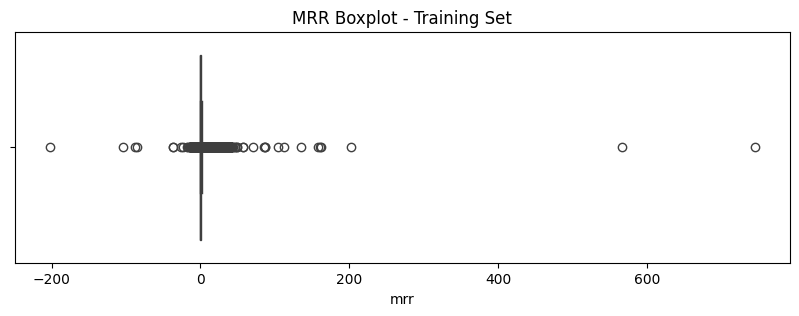

In [ ]:
plt.figure(figsize=(10,3))
sns.boxplot(x=training_df["mrr"])
plt.title("MRR Boxplot - Training Set")
plt.show()


In [ ]:
training_df["mrr"] = training_df["mrr"].clip(lower=0)

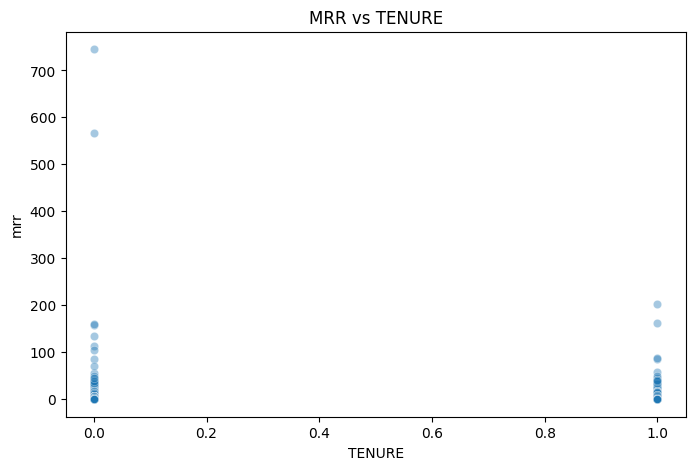

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=training_df, x="TENURE", y="mrr", alpha=0.4)
plt.title("MRR vs TENURE")
plt.show()


In [ ]:
training_df.loc[training_df['mrr']>200] # clipping them to 99th percentile

,PK_INVOICES,FK_DATE_INVOICE,CUSTOMER_START_DATE,TENURE,FLG_DWH_CUSTOMER_IS_BUSINESS,FK_DWH_CUSTOMERS,FK_SUBSCRIPTIONS,PRODUCT_GROUP,PRODUCT_SUBCATEGORY,mrr,ORIGIN_SUBGROUP,ORIGIN_GROUP,noise
34296,90910506,20230214,20230201,0,1,42158232,55697037,NON-DESCRIPTIVE (DEBIT),Other,745.0627,Not Coded,Organic Traffic,False
56124,41628191,20230419,20230301,1,0,62604125,87370582,NON-DESCRIPTIVE (DEBIT),Other,202.0785,Pay Per Click (PPC),Paid Traffic,False
76056,81714471,20230117,20230101,0,1,80712598,43229864,NON-DESCRIPTIVE (DEBIT),Other,566.8000,Direct Access,Direct Access,False


In [ ]:
upper = training_df["mrr"].quantile(0.99)

training_df["mrr"] = training_df["mrr"].clip(upper=upper)

# Aggregation training

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import entropy

def build_customer_features(df, is_train=True):
    """
    Create customer-level aggregated features from raw subscription-invoice data.

    df : training_df or validation_df
    is_train : True → expects noise, False → skips noise aggregation
    """

    df = df.copy()

    # ----------------------------------------
    # 1. Helper functions
    # ----------------------------------------

    def freq_top(x):
        return x.value_counts().index[0] if len(x.dropna()) else np.nan

    def entropy_safe(x):
        vc = x.value_counts(normalize=True)
        if len(vc) <= 1:
            return 0
        return entropy(vc)

    # ----------------------------------------
    # 2. Pivot MRR by TENURE
    # ----------------------------------------

    mrr_pivot = df.pivot_table(
        index="FK_DWH_CUSTOMERS",
        columns="TENURE",
        values="mrr",
        aggfunc="sum"
    )

    # rename and fill missing months
    mrr_pivot = mrr_pivot.rename(columns={0:"mrr_tenure_0", 1:"mrr_tenure_1"})
    mrr_pivot["mrr_tenure_0"] = mrr_pivot["mrr_tenure_0"].fillna(0)
    mrr_pivot["mrr_tenure_1"] = mrr_pivot["mrr_tenure_1"].fillna(0)

    # derived MRR features
    mrr_pivot["mrr_trend_0_1"] = mrr_pivot["mrr_tenure_1"] - mrr_pivot["mrr_tenure_0"]
    mrr_pivot["mrr_ratio_1_0"] = (
        mrr_pivot["mrr_tenure_1"] / (mrr_pivot["mrr_tenure_0"] + 1e-5)
    )
    mrr_pivot["mrr_pct_change"] = (
        (mrr_pivot["mrr_tenure_1"] - mrr_pivot["mrr_tenure_0"])
        / (abs(mrr_pivot["mrr_tenure_0"]) + 1e-5)
    )

    mrr_values = mrr_pivot[["mrr_tenure_0","mrr_tenure_1"]].values
    mrr_pivot["mrr_cv"] = np.std(mrr_values, axis=1) / (np.mean(mrr_values, axis=1) + 1e-5)

    # ----------------------------------------
    # 3. Main Aggregation at customer level
    # ----------------------------------------

    agg_dict = dict(
        n_invoices=("PK_INVOICES", "nunique"),
        min_invoice_date=("FK_DATE_INVOICE", "min"),
        max_invoice_date=("FK_DATE_INVOICE", "max"),
        invoice_date_span=("FK_DATE_INVOICE", lambda x: x.max() - x.min()),

        start_date_min=("CUSTOMER_START_DATE", "min"),
        start_date_max=("CUSTOMER_START_DATE", "max"),

        is_business=("FLG_DWH_CUSTOMER_IS_BUSINESS", "max"),

        n_subscriptions=("FK_SUBSCRIPTIONS", "nunique"),

        mrr_min=("mrr", "min"),
        mrr_max=("mrr", "max"),
        mrr_mean=("mrr", "mean"),

        n_product_groups=("PRODUCT_GROUP", "nunique"),
        main_product_group=("PRODUCT_GROUP", freq_top),
        product_group_entropy=("PRODUCT_GROUP", entropy_safe),

        n_product_subcat=("PRODUCT_SUBCATEGORY", "nunique"),
        main_product_subcat=("PRODUCT_SUBCATEGORY", freq_top),
        product_subcat_entropy=("PRODUCT_SUBCATEGORY", entropy_safe),


        n_origin_groups=("ORIGIN_GROUP", "nunique"),
        n_origin_subgroups=("ORIGIN_SUBGROUP", "nunique"),

        main_origin_group=("ORIGIN_GROUP", freq_top),
        main_origin_subgroup=("ORIGIN_SUBGROUP", freq_top)
    )

    # Add noise only for training
    if is_train:
        agg_dict["noise"] = ("noise", "max")

    agg_df = df.groupby("FK_DWH_CUSTOMERS").agg(**agg_dict).reset_index()

    # ----------------------------------------
    # 4. Merge temporal MRR features
    # ----------------------------------------

    agg_df = agg_df.merge(mrr_pivot, on="FK_DWH_CUSTOMERS", how="left")

    # ----------------------------------------
    # 5. Derived enriched features
    # ----------------------------------------

    # per-subscription revenue
    agg_df["mrr_per_subscription"] = (
        agg_df["mrr_mean"] / (agg_df["n_subscriptions"] + 1e-5)
    )

    # activity rate
    agg_df["activity_rate"] = (
        agg_df["n_invoices"] / (agg_df["n_subscriptions"] + 1e-5)
    )

    # invoice date parts
    agg_df["invoice_min_day"]   = agg_df["min_invoice_date"] % 100
    agg_df["invoice_min_month"] = (agg_df["min_invoice_date"] // 100) % 100
    agg_df["invoice_max_day"]   = agg_df["max_invoice_date"] % 100
    agg_df["invoice_max_month"] = (agg_df["max_invoice_date"] // 100) % 100

    # start date parts
    agg_df["start_month"] = (agg_df["start_date_min"] // 100) % 100

    # final target cast
    if is_train:
        agg_df["noise"] = agg_df["noise"].astype(int)

    # ----------------------------------------
    # 6. Cleanup
    # ----------------------------------------

    agg_df = agg_df.drop(
        columns=["min_invoice_date", "max_invoice_date",
                 "start_date_min", "start_date_max"]
    )

    return agg_df


In [ ]:
customer_training_df = build_customer_features(training_df, is_train=True)

print(customer_training_df.shape)


(22673, 32)


In [ ]:
customer_training_df.head()

,FK_DWH_CUSTOMERS,n_invoices,invoice_date_span,is_business,n_subscriptions,mrr_min,mrr_max,mrr_mean,n_product_groups,main_product_group,product_group_entropy,n_product_subcat,main_product_subcat,product_subcat_entropy,n_origin_groups,n_origin_subgroups,main_origin_group,main_origin_subgroup,noise,mrr_tenure_0,mrr_tenure_1,mrr_trend_0_1,mrr_ratio_1_0,mrr_pct_change,mrr_cv,mrr_per_subscription,activity_rate,invoice_min_day,invoice_min_month,invoice_max_day,invoice_max_month,start_month
0,623,1,0,1,1,0.0009,0.0009,0.000900,1,Local ccTLD,0.000000,1,Domain Names,0.000000,1,1,Paid Traffic,Pay Per Click (PPC),0,0.0009,0.0009,0.0000,0.989011,0.000000,0.000000,0.000900,0.999990,19,2,19,2,2
1,5045,3,0,1,3,0.7516,5.6332,2.068625,3,Other TLDs,1.039721,3,Domain Names,1.039721,1,1,Organic Traffic,Search Engines,0,6.3848,1.8897,-4.4951,0.295968,-0.704030,0.543246,0.689539,0.999997,27,2,27,2,2
2,7999,2,0,1,2,0.0009,0.0937,0.047275,1,Local ccTLD,0.000000,1,Domain Names,0.000000,1,1,Paid Traffic,Pay Per Click (PPC),1,0.0945,0.0946,0.0001,1.000952,0.001058,0.000529,0.023637,0.999995,22,3,22,3,3
3,11573,2,14,1,2,1.7952,1.7968,1.796000,1,Local ccTLD,0.000000,1,Domain Names,0.000000,1,1,Paid Traffic,Pay Per Click (PPC),0,3.5904,3.5936,0.0032,1.000888,0.000891,0.000445,0.897996,0.999995,9,3,23,3,3
4,15047,1,0,1,1,0.0931,0.0936,0.093350,1,Local ccTLD,0.000000,1,Domain Names,0.000000,1,1,Paid Traffic,Pay Per Click (PPC),0,0.0931,0.0936,0.0005,1.005263,0.005370,0.002678,0.093349,0.999990,23,2,23,2,2


In [ ]:
customer_training_df.isna().sum()

,0
FK_DWH_CUSTOMERS,0
n_invoices,0
invoice_date_span,0
is_business,0
n_subscriptions,0
mrr_min,0
mrr_max,0
mrr_mean,0
n_product_groups,0
main_product_group,0


In [ ]:
customer_training_df.noise.value_counts()

,count
noise,
1,14089
0,8584


In [ ]:
customer_training_df.describe() #n_origin_groups	n_origin_subgroups	are always = 1 -> drop them

,FK_DWH_CUSTOMERS,n_invoices,invoice_date_span,is_business,n_subscriptions,mrr_min,mrr_max,mrr_mean,n_product_groups,product_group_entropy,n_product_subcat,product_subcat_entropy,n_origin_groups,n_origin_subgroups,noise,mrr_tenure_0,mrr_tenure_1,mrr_trend_0_1,mrr_ratio_1_0,mrr_pct_change,mrr_cv,mrr_per_subscription,activity_rate,invoice_min_day,invoice_min_month,invoice_max_day,invoice_max_month,start_month
count,2.267300e+04,22673.000000,22673.000000,22673.000000,22673.000000,22673.000000,22673.000000,22673.000000,22673.000000,22673.000000,22673.000000,22673.000000,22673.0,22673.0,22673.000000,22673.000000,22673.000000,22673.000000,22673.000000,22673.000000,22673.000000,22673.000000,22673.000000,22673.000000,22673.000000,22673.000000,22673.000000,22673.000000
mean,4.994565e+07,2.324262,51.013452,0.622635,2.138799,0.169618,1.667291,0.640375,1.814008,0.483167,1.506902,0.308687,1.0,1.0,0.621400,1.280365,2.023216,0.742851,11.234296,10.237893,0.161071,0.308080,1.067176,15.874917,3.495082,15.955542,3.682442,3.434217
std,2.887409e+07,1.704301,626.833839,0.484738,1.434746,0.693259,3.149715,1.208511,0.807534,0.423569,0.642913,0.370302,0.0,0.0,0.485049,3.128569,4.681464,3.113673,238.462060,238.462280,0.308421,0.764046,0.178207,8.747999,1.813627,8.740458,1.846046,1.704483
min,6.230000e+02,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.0,1.0,0.000000,0.000000,0.000000,-39.630300,0.000000,-0.999999,0.000000,0.000000,0.999990,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.470266e+07,1.000000,0.000000,0.000000,1.000000,0.000900,0.000900,0.000900,1.000000,0.000000,1.000000,0.000000,1.0,1.0,0.000000,0.001800,0.000900,0.000000,0.989011,0.000000,0.000000,0.000900,0.999990,8.000000,2.000000,8.000000,2.000000,2.000000
50%,4.999744e+07,2.000000,0.000000,1.000000,2.000000,0.000900,0.096100,0.093300,2.000000,0.636514,1.000000,0.000000,1.0,1.0,1.000000,0.104900,0.094500,0.000000,0.995692,0.000000,0.000529,0.026660,0.999995,16.000000,3.000000,16.000000,4.000000,3.000000
75%,7.517110e+07,3.000000,0.000000,1.000000,3.000000,0.093100,1.135400,0.690333,2.000000,0.693147,2.000000,0.693147,1.0,1.0,1.000000,1.138100,0.939800,0.002300,1.005212,0.005319,0.026775,0.287297,0.999997,23.000000,5.000000,23.000000,5.000000,5.000000
max,9.999906e+07,56.000000,20396.000000,1.000000,56.000000,12.406600,12.406600,12.406600,7.000000,1.791759,5.000000,1.579233,1.0,1.0,1.000000,89.482600,90.782700,52.414000,12396.078431,12395.098039,0.999998,12.406476,7.999920,31.000000,12.000000,31.000000,12.000000,6.000000


In [ ]:
customer_training_df.drop(['n_origin_groups','n_origin_subgroups'], axis=1, inplace=True)

In [ ]:
customer_training_df.describe(include='object')

,main_product_group,main_product_subcat,main_origin_group,main_origin_subgroup
count,22673,22673,22673,22673
unique,21,15,4,7
top,Local ccTLD,Domain Names,Paid Traffic,Pay Per Click (PPC)
freq,14103,19345,14341,13318


# Preprocessing validation set

In [ ]:
val_df = pd.read_csv('validation.csv')
print(val_df.shape)
val_df.FK_DWH_CUSTOMERS.nunique()

(42055, 12)


11590

In [ ]:
display(val_df.isna().sum()) # ok same null to handle



,0
PK_INVOICES,0
FK_DATE_INVOICE,0
CUSTOMER_START_DATE,0
TENURE,0
FLG_DWH_CUSTOMER_IS_BUSINESS,0
FK_DWH_CUSTOMERS,0
FK_SUBSCRIPTIONS,0
PRODUCT_GROUP,0
PRODUCT_SUBCATEGORY,0
mrr,0


In [ ]:
val_df["mrr"] = val_df["mrr"].clip(lower=0)

In [ ]:
val_df.describe() # tenure is ok in this case while mrr is to be handled

,PK_INVOICES,FK_DATE_INVOICE,CUSTOMER_START_DATE,TENURE,FLG_DWH_CUSTOMER_IS_BUSINESS,FK_DWH_CUSTOMERS,FK_SUBSCRIPTIONS,mrr
count,4.205500e+04,4.205500e+04,4.205500e+04,42055.000000,42055.000000,4.205500e+04,4.205500e+04,42055.000000
mean,5.005509e+07,2.024017e+07,2.024020e+07,0.488408,0.589466,5.048503e+07,4.956359e+07,0.924245
std,2.895853e+07,2.024119e+03,8.333385e+01,0.499872,0.491937,2.911931e+07,2.880982e+07,3.021525
min,2.832000e+03,2.017033e+07,2.024010e+07,0.000000,0.000000,4.068000e+03,2.980000e+02,0.000000
25%,2.491256e+07,2.024012e+07,2.024010e+07,0.000000,0.000000,2.503290e+07,2.455114e+07,0.000900
50%,5.010655e+07,2.024022e+07,2.024020e+07,0.000000,1.000000,5.100506e+07,4.912832e+07,0.000900
75%,7.518769e+07,2.024031e+07,2.024030e+07,1.000000,1.000000,7.577132e+07,7.458435e+07,0.388800
max,9.999371e+07,2.025102e+07,2.024030e+07,1.000000,1.000000,9.999928e+07,9.998860e+07,194.542900


In [ ]:
val_df = val_df.loc[val_df['TENURE']>=0] # no need but to be coherent with preprocessing (better to create a pipeline)
# Fix categoricals
for col in ["ORIGIN_SUBGROUP", "ORIGIN_GROUP"]:
    val_df.fillna({col: "Unknown"}, inplace=True)



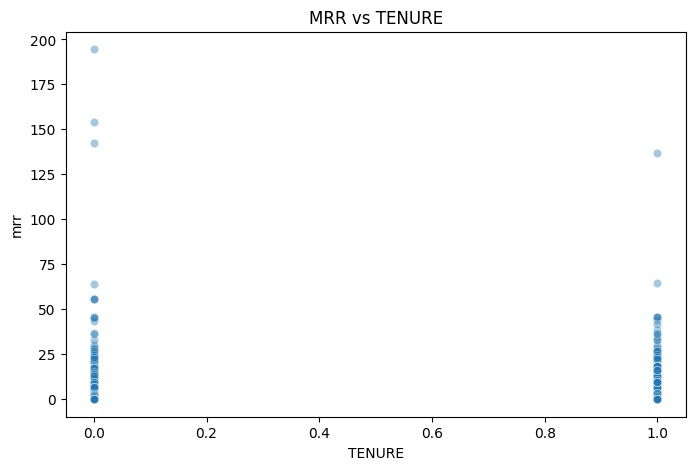

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=val_df, x="TENURE", y="mrr", alpha=0.4)
plt.title("MRR vs TENURE")
plt.show()


In [ ]:
upper = training_df["mrr"].quantile(0.99) #using the upper of training set to avoid leakage

val_df["mrr"] = val_df["mrr"].clip(upper=upper)

## Aggregation validation

In [ ]:
customer_val_df = build_customer_features(val_df, is_train=False)
print(customer_val_df.shape)


(11590, 31)


In [ ]:
customer_val_df.head()

,FK_DWH_CUSTOMERS,n_invoices,invoice_date_span,is_business,n_subscriptions,mrr_min,mrr_max,mrr_mean,n_product_groups,main_product_group,product_group_entropy,n_product_subcat,main_product_subcat,product_subcat_entropy,n_origin_groups,n_origin_subgroups,main_origin_group,main_origin_subgroup,mrr_tenure_0,mrr_tenure_1,mrr_trend_0_1,mrr_ratio_1_0,mrr_pct_change,mrr_cv,mrr_per_subscription,activity_rate,invoice_min_day,invoice_min_month,invoice_max_day,invoice_max_month,start_month
0,4068,1,0,1,1,0.0009,0.0009,0.000900,1,Local ccTLD,0.000000,1,Domain Names,0.000000,1,1,Paid Traffic,Pay Per Click (PPC),0.0009,0.0009,0.0000,0.989011,0.000000,0.000000,0.000900,0.999990,8,3,8,3,3
1,7263,4,71,1,4,0.8732,1.1703,0.972733,2,Local ccTLD,0.636514,2,Domain Names,0.636514,1,1,Organic Traffic,Not Coded,2.9107,2.9257,0.0150,1.005150,0.005153,0.002570,0.243183,0.999998,30,1,1,2,1
2,13310,3,100,1,2,0.0009,7.0047,3.500100,2,Local ccTLD,0.693147,2,Domain Names,0.693147,1,1,Organic Traffic,Search Engines,7.0056,6.9948,-0.0108,0.998457,-0.001542,0.000771,1.750041,1.499993,9,3,9,4,3
3,17953,3,100,1,2,0.0009,3.4911,0.876150,2,Local ccTLD,0.693147,2,Domain Names,0.693147,1,1,Paid Traffic,Pay Per Click (PPC),0.0126,3.4920,3.4794,276.923077,275.923870,0.992804,0.438073,1.499993,16,3,16,4,3
4,19548,1,0,1,1,0.5838,0.5842,0.584000,1,Local ccTLD,0.000000,1,Domain Names,0.000000,1,1,Direct Access,Direct Access,0.5842,0.5838,-0.0004,0.999298,-0.000685,0.000342,0.583994,0.999990,26,2,26,2,2


In [ ]:
customer_val_df.drop(['n_origin_groups','n_origin_subgroups'], axis=1, inplace=True) #remove as before

In [ ]:
customer_val_df.isna().sum()

,0
FK_DWH_CUSTOMERS,0
n_invoices,0
invoice_date_span,0
is_business,0
n_subscriptions,0
mrr_min,0
mrr_max,0
mrr_mean,0
n_product_groups,0
main_product_group,0


## Check if data is coherent between training and validation

In [ ]:
assert (customer_training_df.drop('noise', axis=1).dtypes == customer_val_df.dtypes).all()

In [ ]:
num_cols = customer_training_df.select_dtypes(include=['int64','float64']).columns
num_cols = [c for c in num_cols if c not in ['FK_DWH_CUSTOMERS','noise'] ]


train_stats = customer_training_df[num_cols].describe().T
val_stats = customer_val_df[num_cols].describe().T

display(train_stats)


,count,mean,std,min,25%,50%,75%,max
n_invoices,22673.0,2.324262,1.704301,1.000000,1.000000,2.000000,3.000000,56.000000
invoice_date_span,22673.0,51.013452,626.833839,0.000000,0.000000,0.000000,0.000000,20396.000000
is_business,22673.0,0.622635,0.484738,0.000000,0.000000,1.000000,1.000000,1.000000
n_subscriptions,22673.0,2.138799,1.434746,1.000000,1.000000,2.000000,3.000000,56.000000
mrr_min,22673.0,0.169618,0.693259,0.000000,0.000900,0.000900,0.093100,12.406600
mrr_max,22673.0,1.667291,3.149715,0.000000,0.000900,0.096100,1.135400,12.406600
mrr_mean,22673.0,0.640375,1.208511,0.000000,0.000900,0.093300,0.690333,12.406600
n_product_groups,22673.0,1.814008,0.807534,1.000000,1.000000,2.000000,2.000000,7.000000
product_group_entropy,22673.0,0.483167,0.423569,0.000000,0.000000,0.636514,0.693147,1.791759
n_product_subcat,22673.0,1.506902,0.642913,1.000000,1.000000,1.000000,2.000000,5.000000


In [ ]:
display(val_stats)

,count,mean,std,min,25%,50%,75%,max
n_invoices,11590.0,2.099223,1.587821,1.00000,1.000000,2.000000,3.000000,43.000000
invoice_date_span,11590.0,45.369370,536.491854,0.00000,0.000000,0.000000,0.000000,20003.000000
is_business,11590.0,0.541760,0.498275,0.00000,0.000000,1.000000,1.000000,1.000000
n_subscriptions,11590.0,1.906989,1.317155,1.00000,1.000000,2.000000,2.000000,43.000000
mrr_min,11590.0,0.186373,0.752137,0.00000,0.000900,0.000900,0.097400,12.406600
mrr_max,11590.0,1.581597,3.122292,0.00000,0.000900,0.193900,1.164300,12.406600
mrr_mean,11590.0,0.629347,1.277142,0.00000,0.000900,0.097200,0.581406,12.406600
n_product_groups,11590.0,1.612683,0.801690,1.00000,1.000000,1.000000,2.000000,8.000000
product_group_entropy,11590.0,0.359525,0.423397,0.00000,0.000000,0.000000,0.693147,2.022809
n_product_subcat,11590.0,1.376531,0.615390,1.00000,1.000000,1.000000,2.000000,6.000000


Having a look at numerical features they all seem similar in range between training and validation, with some minimal difference in mrr distribution

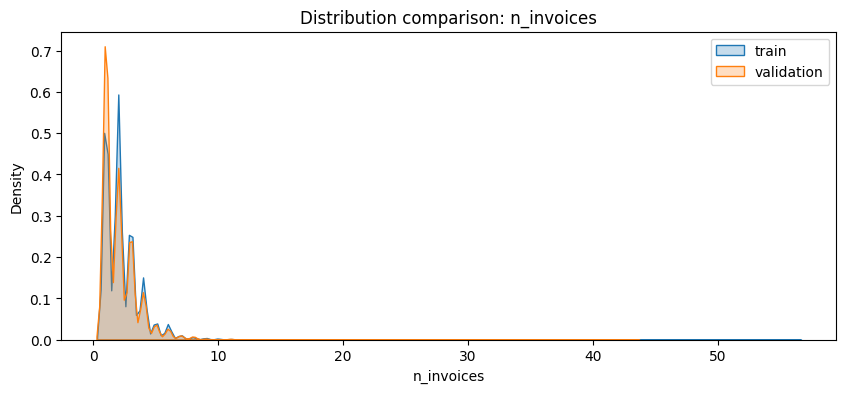

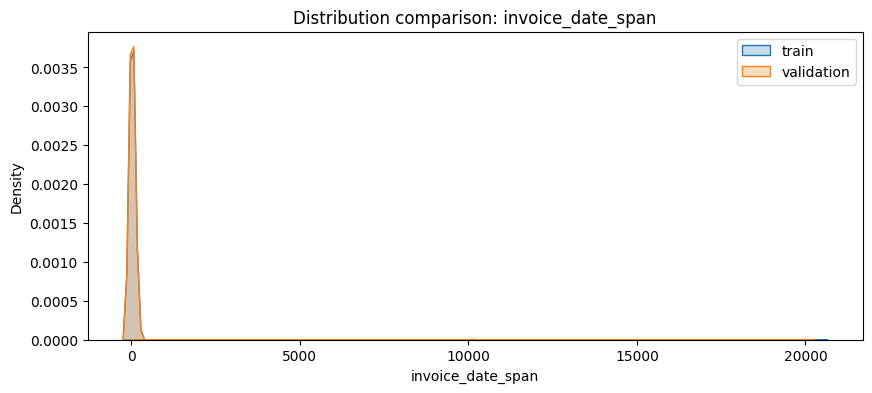

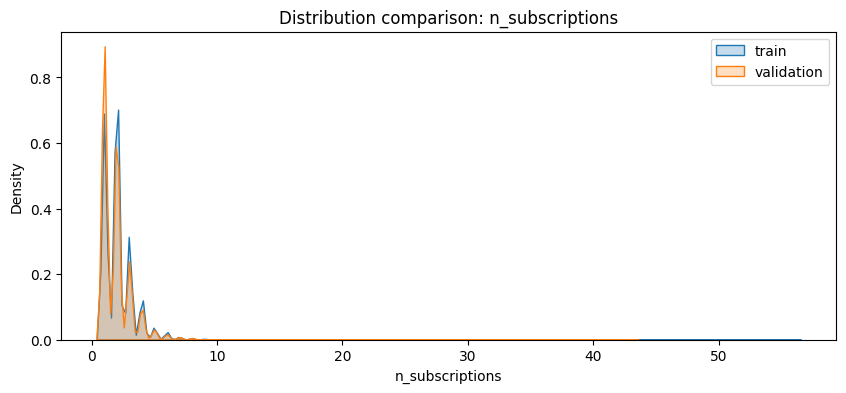

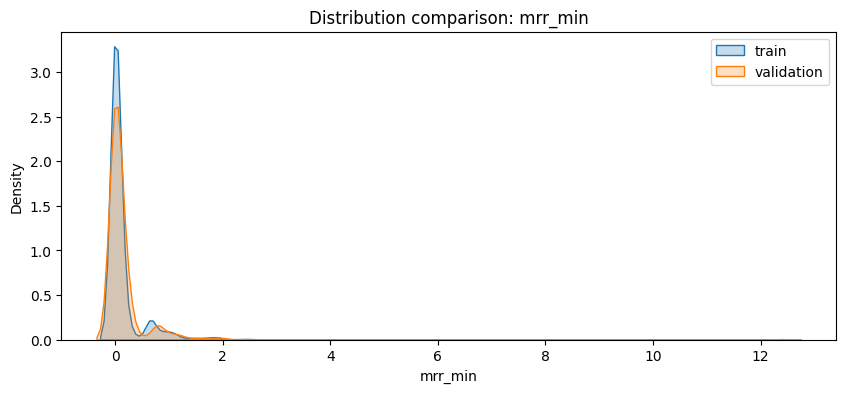

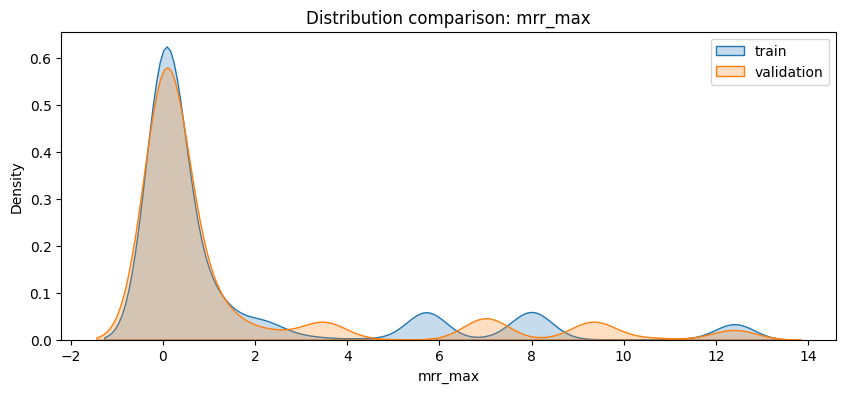

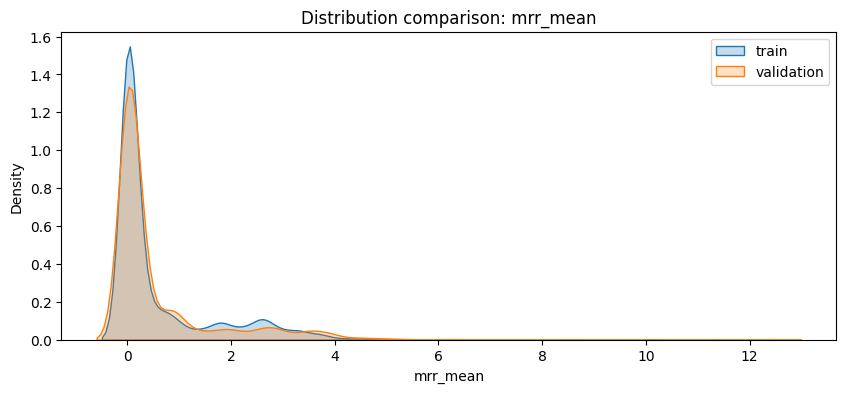

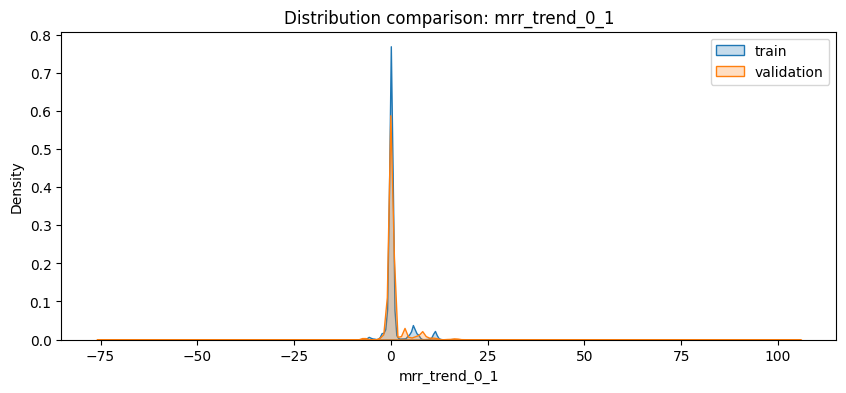

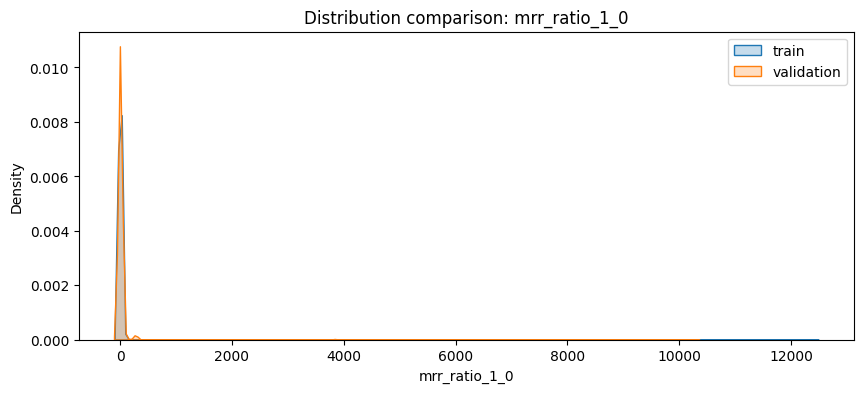

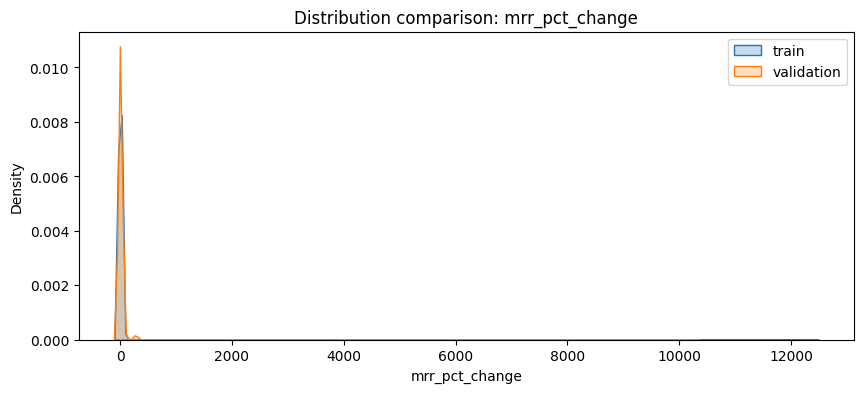

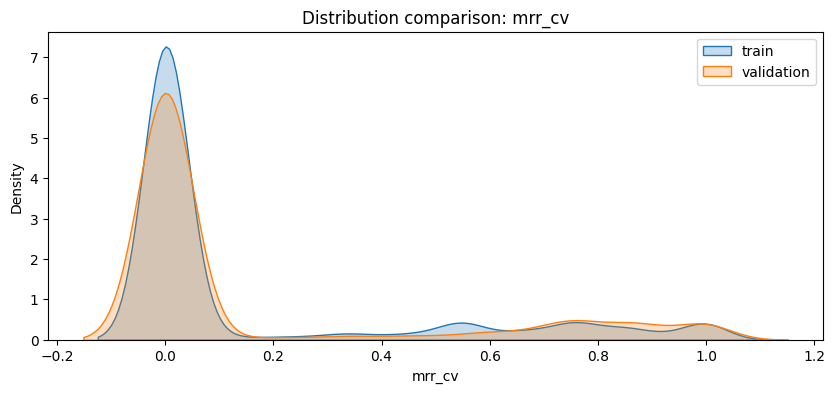

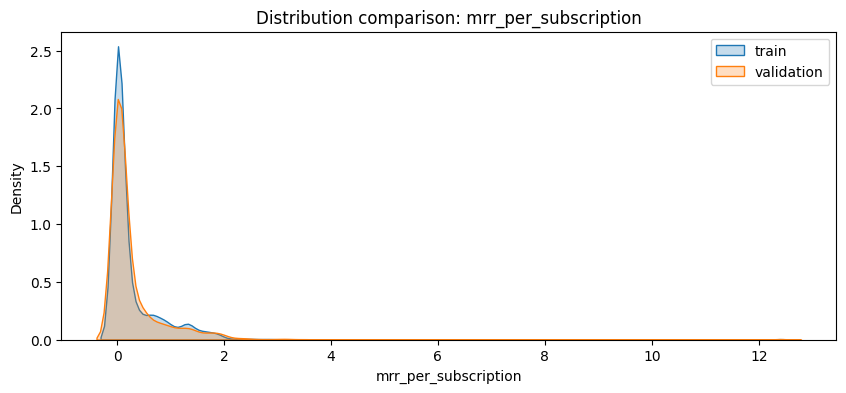

In [ ]:


cols_to_plot = [
    'n_invoices', 'invoice_date_span', 'n_subscriptions',
    'mrr_min', 'mrr_max', 'mrr_mean', 'mrr_trend_0_1', 'mrr_ratio_1_0',
    'mrr_pct_change','mrr_cv','mrr_per_subscription'
]

for col in cols_to_plot:
    plt.figure(figsize=(10,4))
    sns.kdeplot(customer_training_df[col], label='train', fill=True)
    sns.kdeplot(customer_val_df[col], label='validation', fill=True)
    plt.title(f"Distribution comparison: {col}")
    plt.legend()
    plt.show()


In [ ]:
cat_cols = customer_training_df.select_dtypes(include=['object']).columns

for col in cat_cols:
    train_vals = set(customer_training_df[col].dropna())
    val_vals = set(customer_val_df[col].dropna())
    unseen = val_vals - train_vals
    if unseen:
        print(f"[WARNING] Column '{col}' has unseen categories in validation:")
        print(unseen)
    else:
        print(f"[OK] Column '{col}' has no unseen categories.")


[OK] Column 'main_product_group' has no unseen categories.
[OK] Column 'main_product_subcat' has no unseen categories.
[OK] Column 'main_origin_group' has no unseen categories.
[OK] Column 'main_origin_subgroup' has no unseen categories.


In [ ]:
for col in cat_cols:
    print(col)
    print("  Train unique:", customer_training_df[col].nunique())
    print("  Val unique:", customer_val_df[col].nunique())


main_product_group
  Train unique: 21
  Val unique: 16
main_product_subcat
  Train unique: 15
  Val unique: 11
main_origin_group
  Train unique: 4
  Val unique: 4
main_origin_subgroup
  Train unique: 7
  Val unique: 7


Also for categoricals we have similar numbers

# EDA training set

In [ ]:
training_set = customer_training_df.drop('FK_DWH_CUSTOMERS', axis=1).copy()

In [ ]:
num_cols = training_set.select_dtypes(include=['int64','float64']).columns
num_cols_no_targ = [c for c in num_cols if c != 'noise']


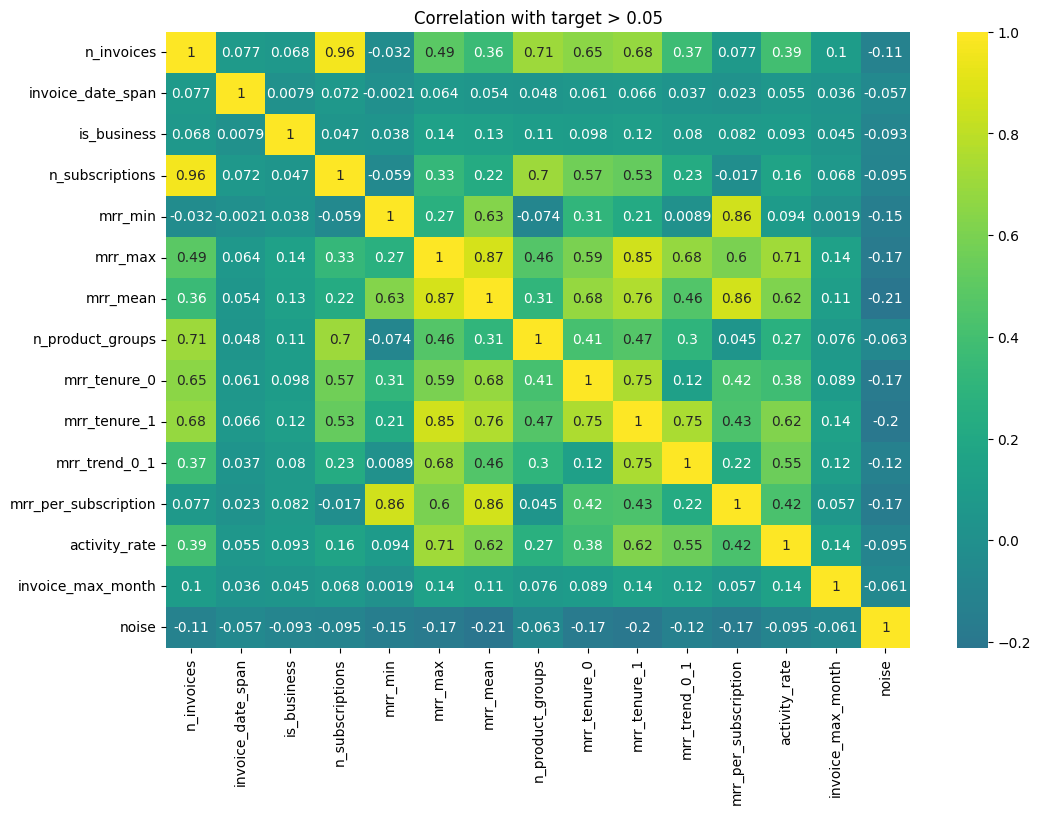

In [ ]:
threshold = 0.05

corr_target = training_set[num_cols].corr()["noise"].drop("noise")
cols_to_keep = corr_target[abs(corr_target) > threshold].index.tolist()

filtered = training_set[cols_to_keep + ["noise"]].corr()

plt.figure(figsize=(12,8))
sns.heatmap(
    filtered,
    cmap='viridis',
    annot=True,
    center=0
)
plt.title(f"Correlation with target > {threshold}")
plt.show()


The matrix confirms good structural consistency in the engineered features (we have positive correlation for example in n_invoice and n_subscriptions, we expect it to happen since > subscriptions = > invoices)
Strong correlation is not a concern for tree-based models, which naturally select the best splitting variable among redundant ones.

The weak correlations with the target highlight a dataset where churn is likely driven by interactions and categorical patterns, not single numeric signals.

MRR features seems to be the most correlated to the target negatively (higher rate of churn = less mrr) and seems logical.

Additional note, this is linear correlation, we might not be capturing some other type of correlation so our dataset is not necessarely not informative


/tmp/ipython-input-17407269.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


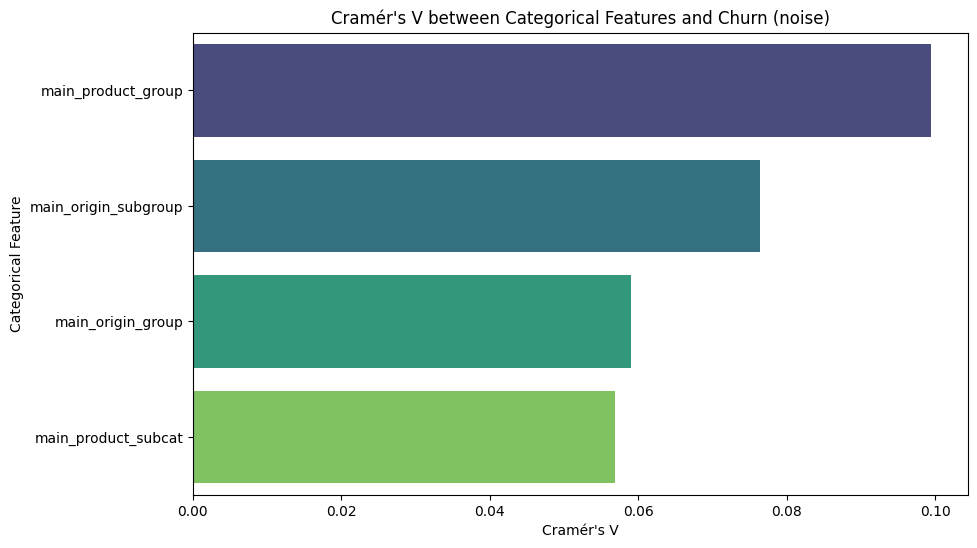

In [ ]:

cat_cols = training_set.select_dtypes(include=['object']).columns

def cramers_v(x, y):
    confusion = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion)[0]
    n = confusion.sum().sum()
    phi2 = chi2/n
    r, k = confusion.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))



cramer_results = []

for col in cat_cols:
    cv = cramers_v(training_set[col], training_set['noise'])
    cramer_results.append((col, cv))

cramer_df = pd.DataFrame(cramer_results, columns=["feature", "cramers_v"])
cramer_df = cramer_df.sort_values("cramers_v", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    data=cramer_df,
    x="cramers_v",
    y="feature",
    palette="viridis"
)
plt.title("Cramér's V between Categorical Features and Churn (noise)")
plt.xlabel("Cramér's V")
plt.ylabel("Categorical Feature")
plt.show()




Product group and origin subgroup seem to be more correlated to the target, even though we have max 0.1 so not a very string predictive power

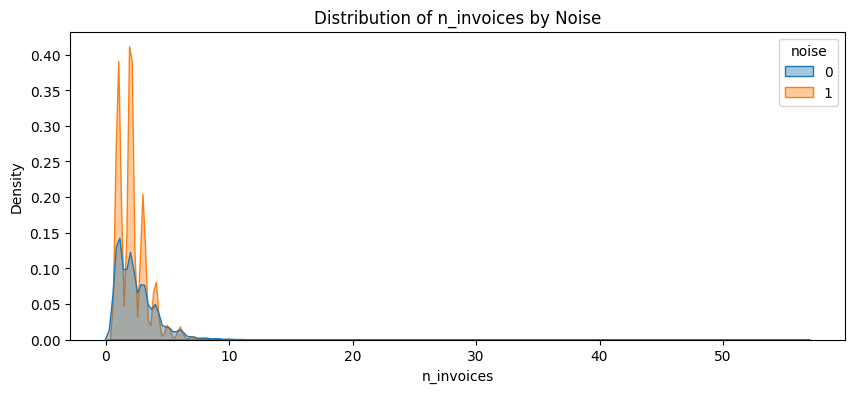

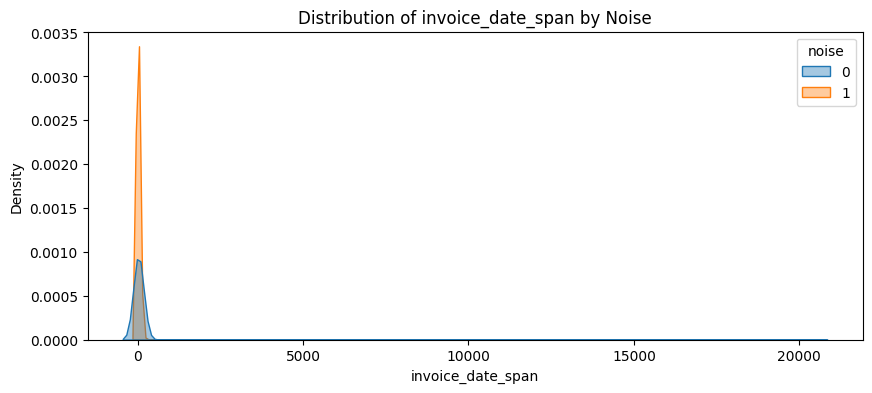

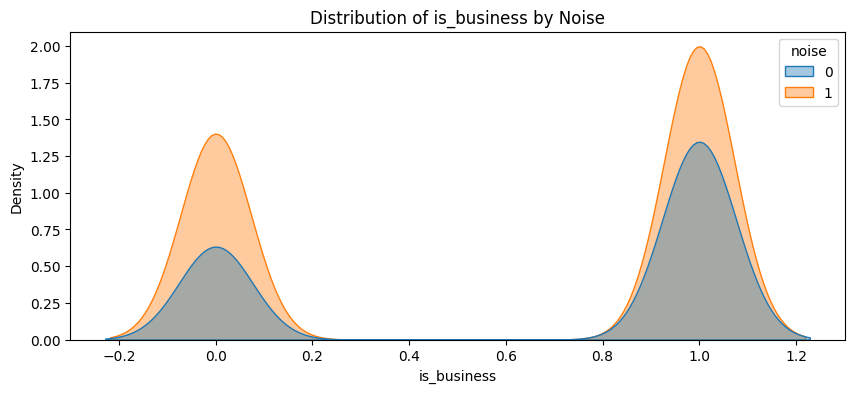

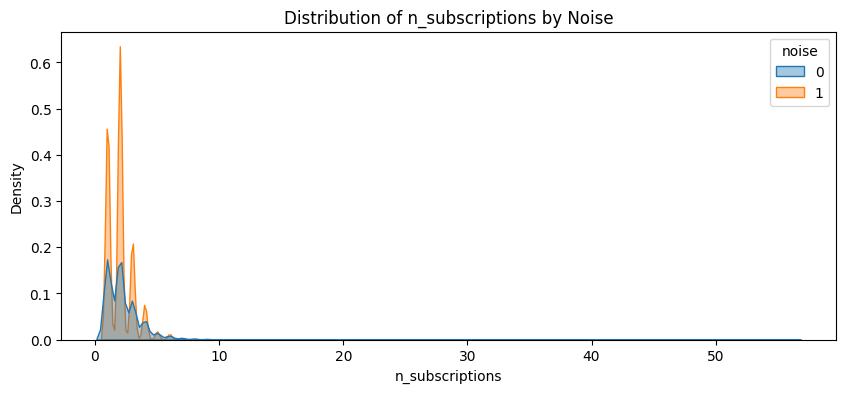

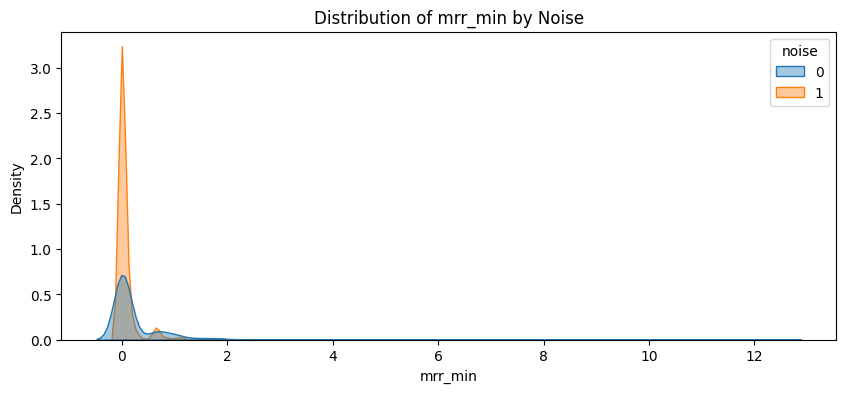

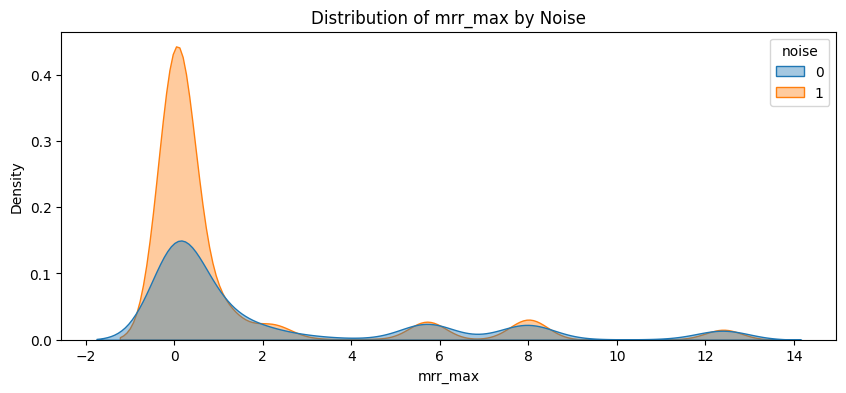

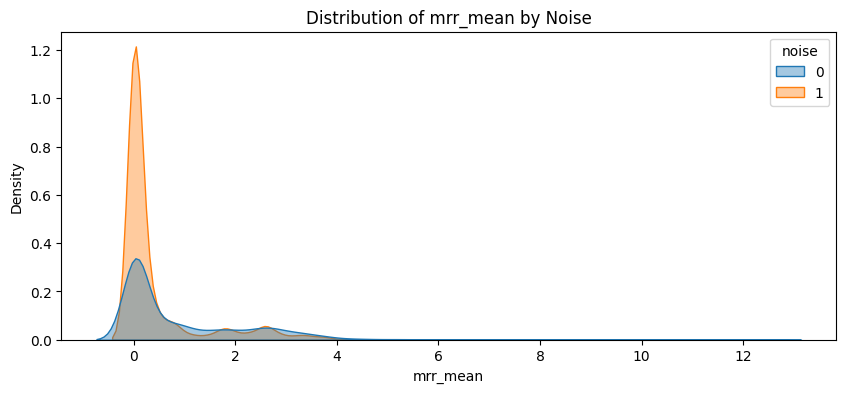

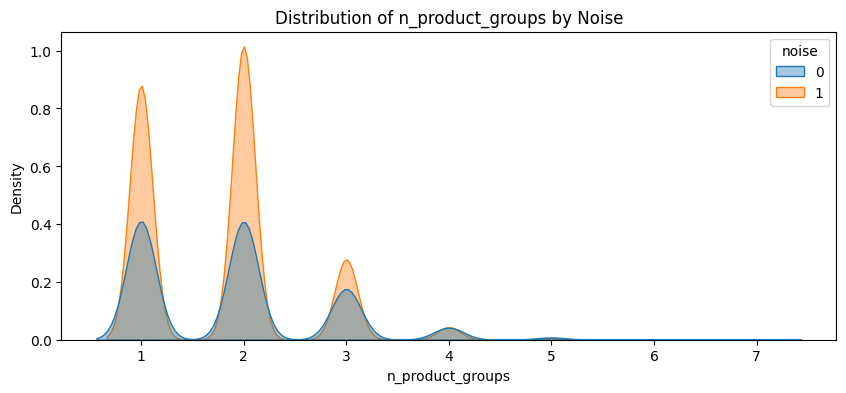

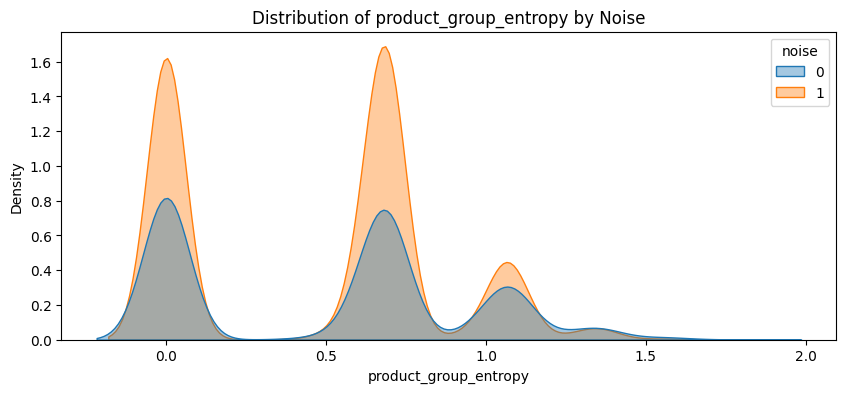

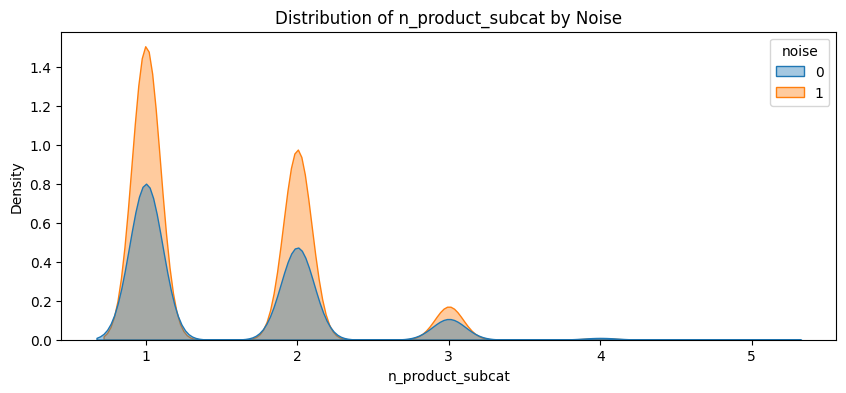

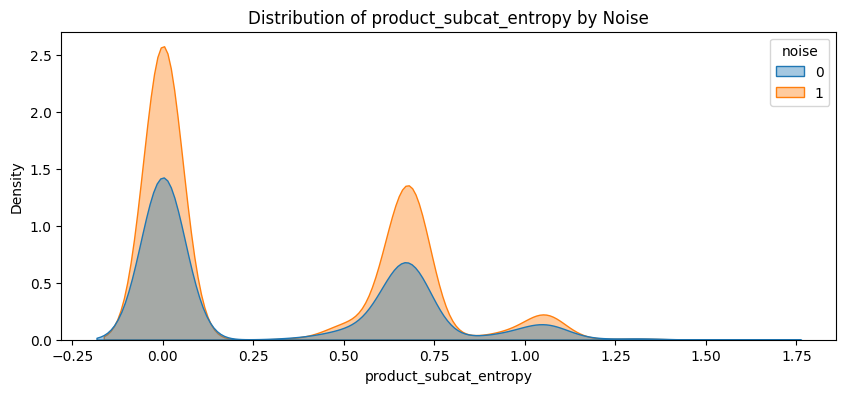

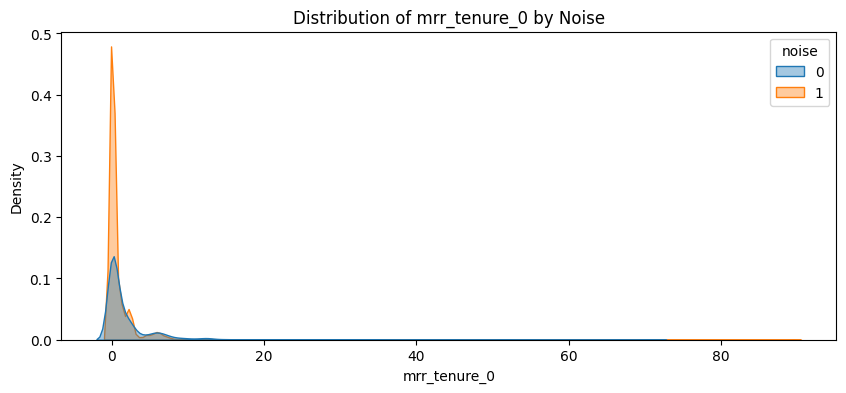

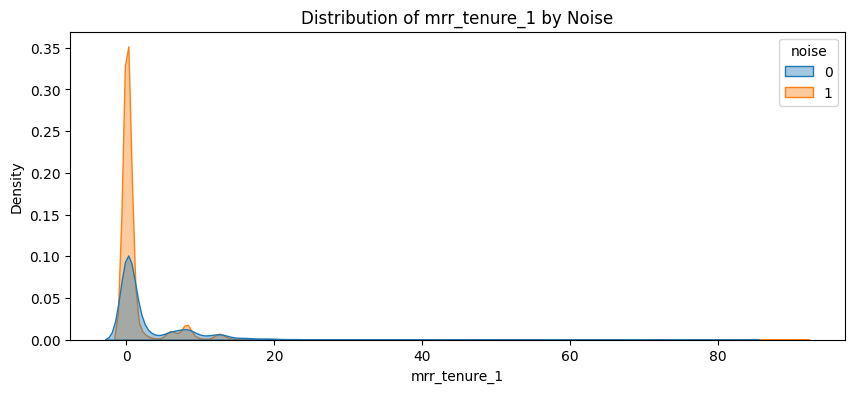

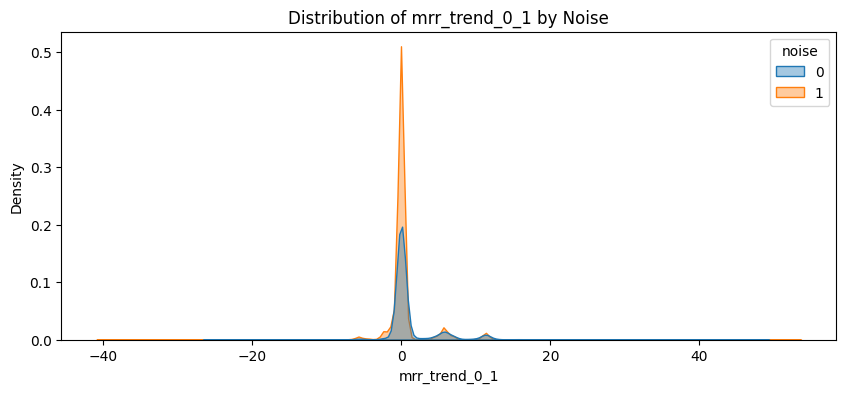

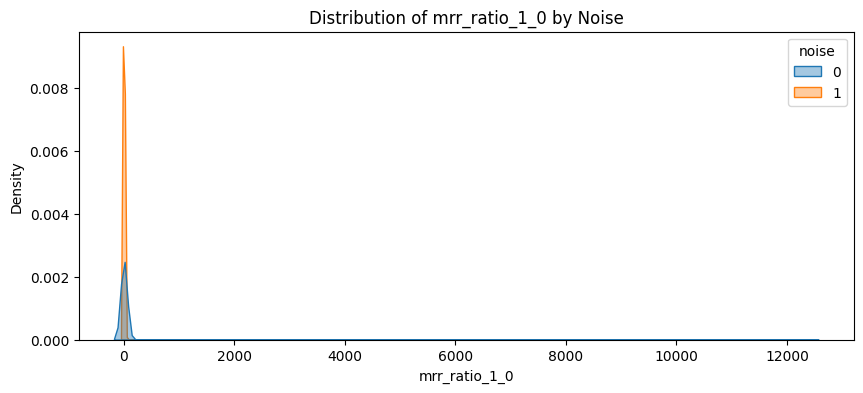

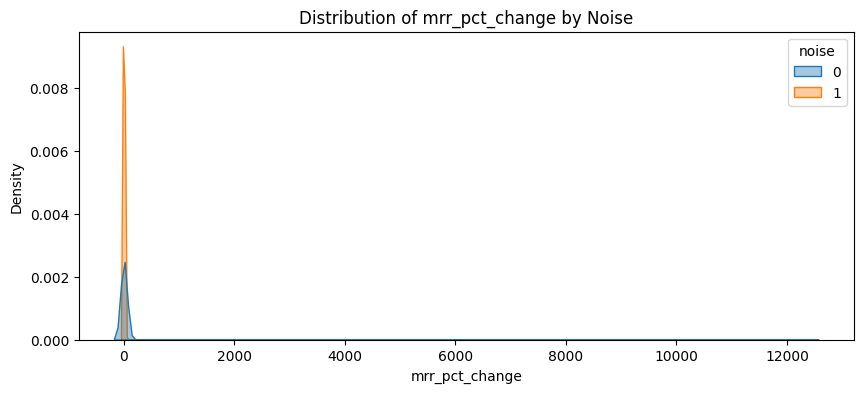

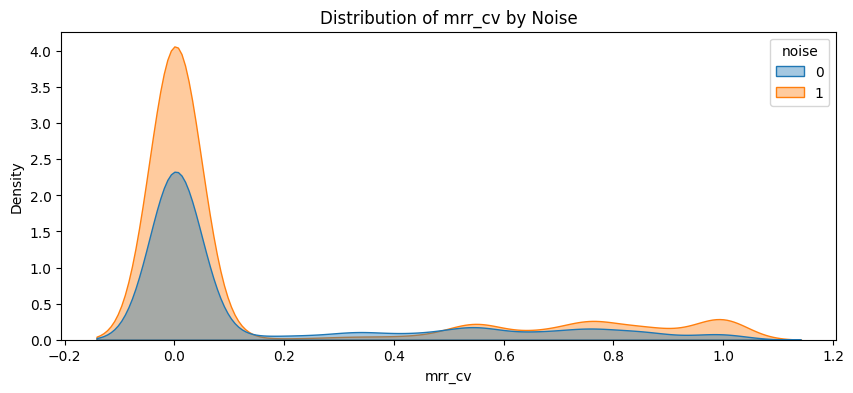

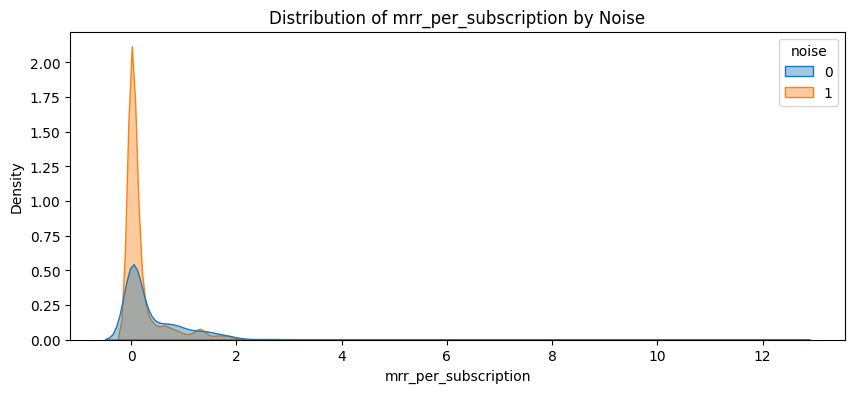

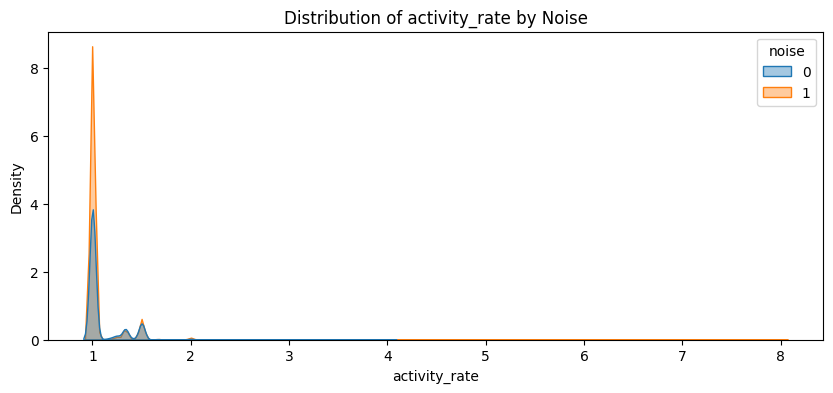

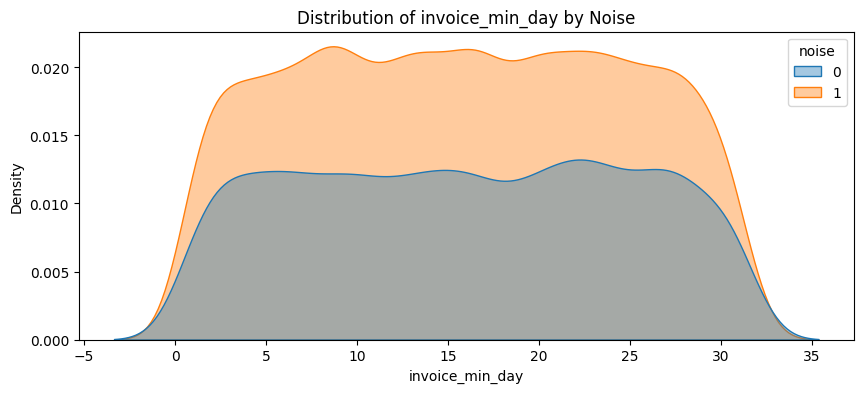

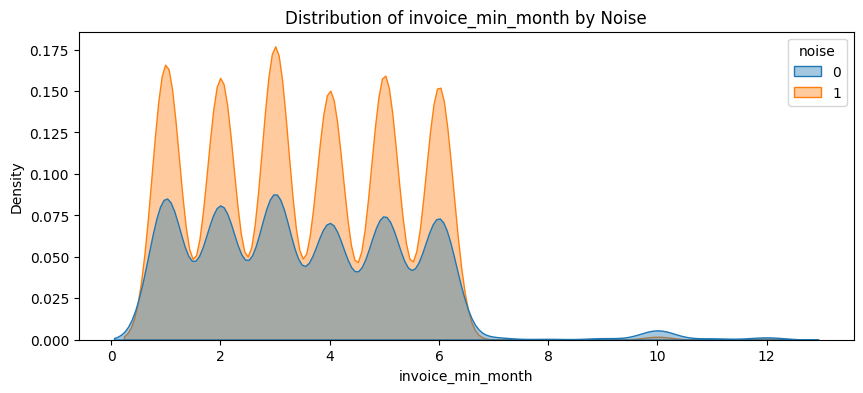

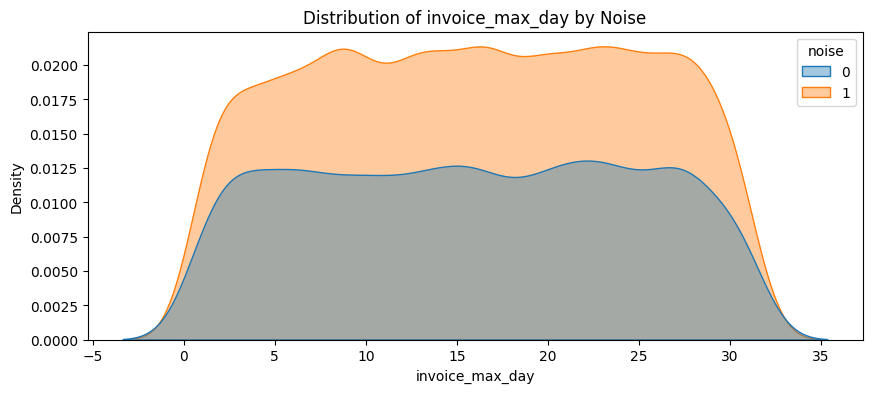

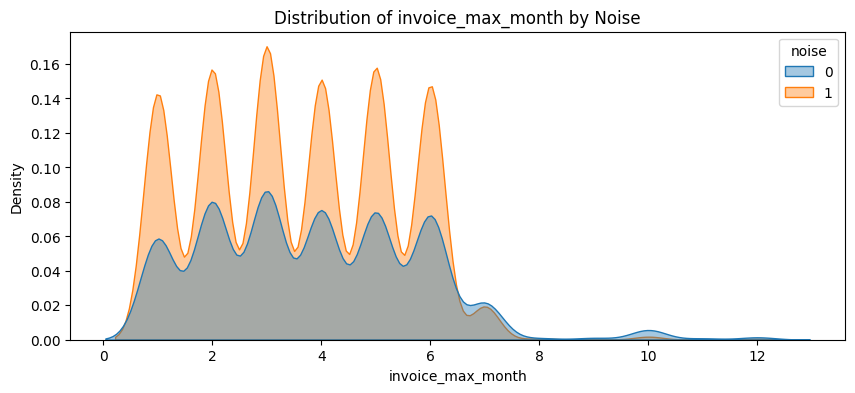

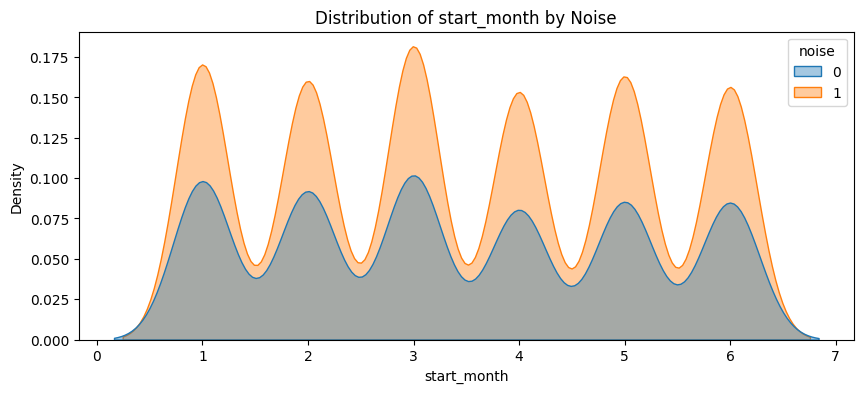

In [ ]:
for col in num_cols_no_targ:
    plt.figure(figsize=(10,4))
    sns.kdeplot(
        data=training_set,
        x=col,
        hue='noise',
        fill=True,
        alpha=.4
    )
    plt.title(f"Distribution of {col} by Noise")
    plt.show()

#none of the numeric features seem to have very different behavior between 1 and 0 (confirm correlation matrix), not powerful feature by itself is detected


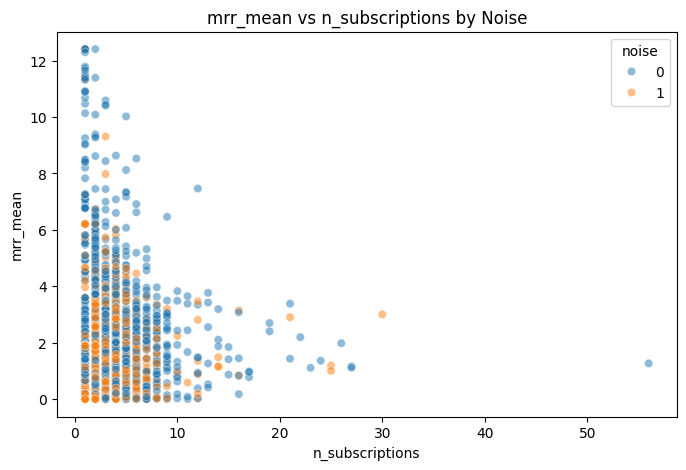

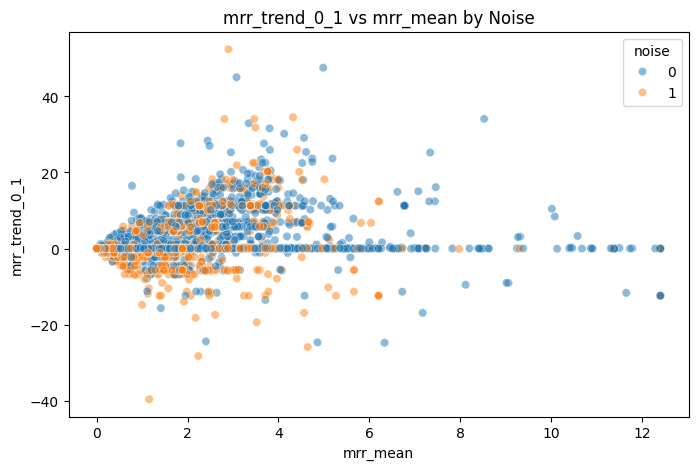

In [ ]:
pairs = [
    ('n_subscriptions', 'mrr_mean'),
    ('mrr_mean', 'mrr_trend_0_1')
]

for x, y in pairs:
    plt.figure(figsize=(8,5))
    sns.scatterplot(
        data=training_set,
        x=x, y=y, hue='noise', alpha=0.5
    )
    plt.title(f"{y} vs {x} by Noise")
    plt.show()


It seems that higher mrr_mean on lower number of subscriptions can be less prone to churn, also a little trend of decreasing mrr can be found in churners (second plot)

/tmp/ipython-input-3952680660.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pct.index, y=pct.values, palette="viridis")


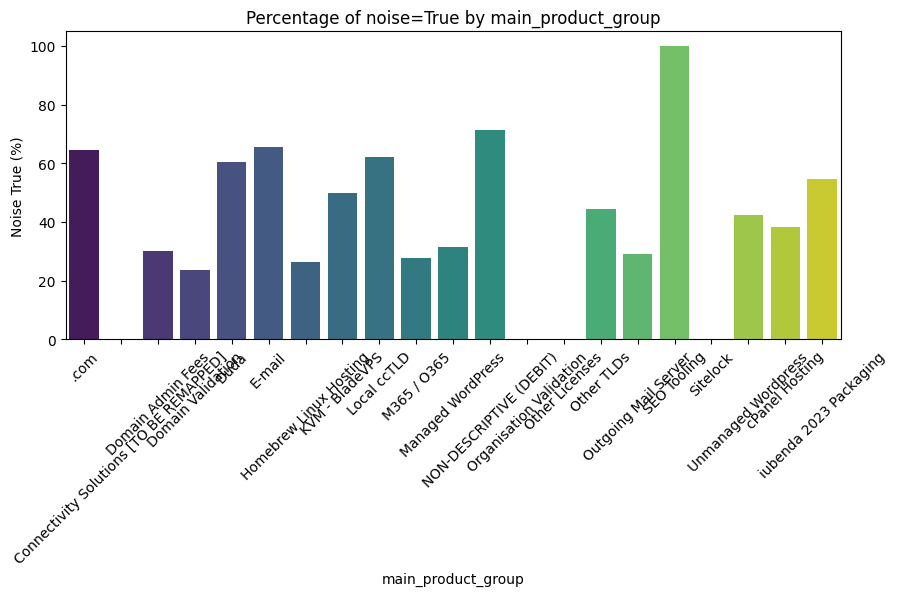

/tmp/ipython-input-3952680660.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pct.index, y=pct.values, palette="viridis")


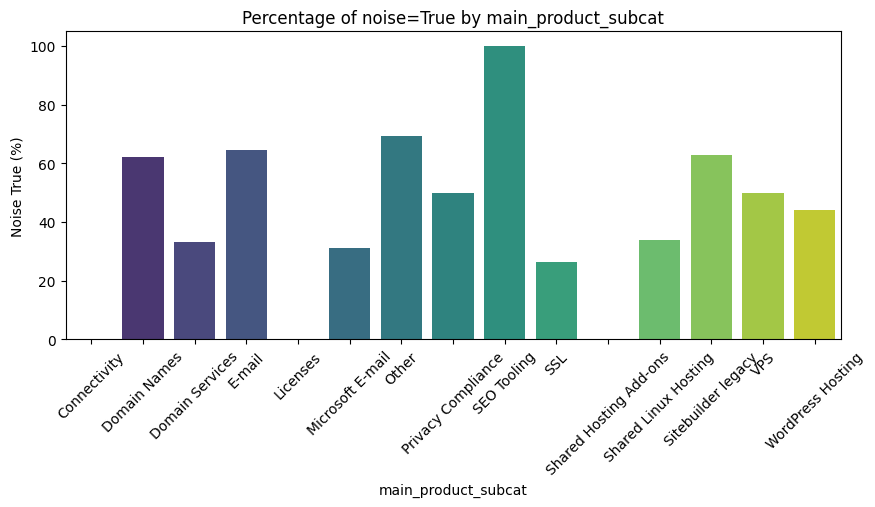

/tmp/ipython-input-3952680660.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pct.index, y=pct.values, palette="viridis")


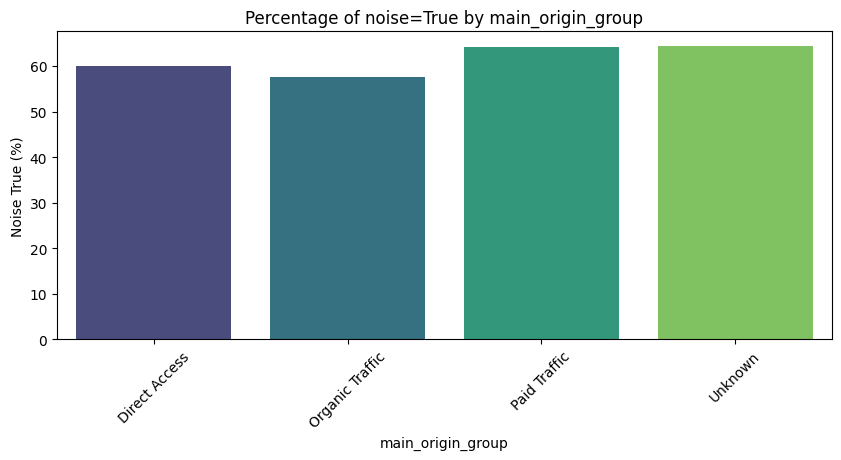

/tmp/ipython-input-3952680660.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pct.index, y=pct.values, palette="viridis")


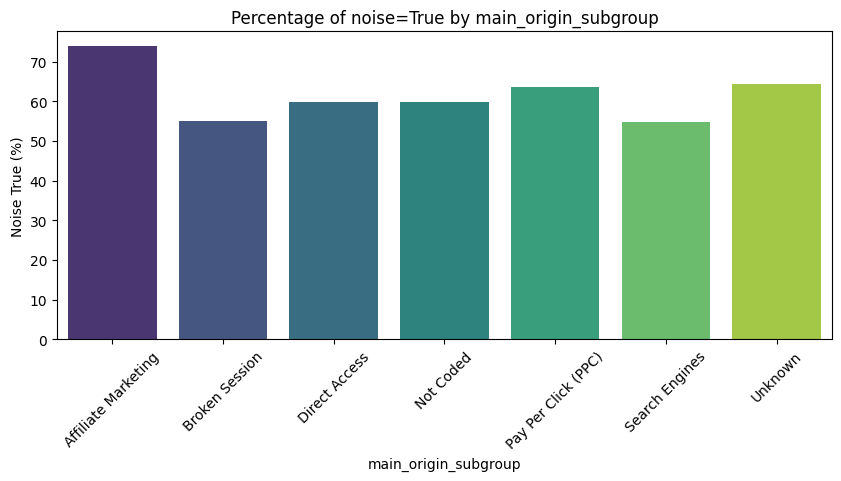

In [ ]:
for col in cat_cols:
    pct = (
        pd.crosstab(training_set[col], training_set['noise'], normalize='index') * 100
    )[1]  # take only noise=True column

    plt.figure(figsize=(10,4))
    sns.barplot(x=pct.index, y=pct.values, palette="viridis")
    plt.title(f"Percentage of noise=True by {col}")
    plt.ylabel("Noise True (%)")
    plt.xticks(rotation=45)
    plt.show()


some categories have higher percentage of churn than others, might be helpful for the model

# Training

In [ ]:

X = training_set.drop(columns=["noise"])
y = training_set["noise"].astype(int)

# split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)


In [ ]:
cat_features = X.select_dtypes(include=['object']).columns.tolist()
cat_features

['main_product_group',
 'main_product_subcat',
 'main_origin_group',
 'main_origin_subgroup']

In [ ]:
w0 = 1
w1 = y.value_counts()[0] / y.value_counts()[1]
print("class weights:", w0, w1)

class weights: 1 0.6092696429838882


In [ ]:


model = CatBoostClassifier(
    class_weights=[w0, w1],
    eval_metric="AUC",
    learning_rate=0.05,
    depth=6,
    iterations=1000,
    random_seed=42,
    early_stopping_rounds=50,
    verbose=50
)

model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    cat_features=cat_features
)


0:	test: 0.6779807	best: 0.6779807 (0)	total: 65.6ms	remaining: 1m 5s
50:	test: 0.7123448	best: 0.7127183 (48)	total: 3.63s	remaining: 1m 7s
100:	test: 0.7167167	best: 0.7167382 (99)	total: 6.24s	remaining: 55.5s
150:	test: 0.7176004	best: 0.7177061 (140)	total: 8.49s	remaining: 47.7s
200:	test: 0.7174194	best: 0.7177421 (188)	total: 11.7s	remaining: 46.5s
250:	test: 0.7173856	best: 0.7180234 (220)	total: 13.4s	remaining: 40.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7180234167
bestIteration = 220

Shrink model to first 221 iterations.


no overfitting detected -> we have similar results both on training and test

In [ ]:
y_pred = model.predict(X_train)
y_prob = model.predict_proba(X_train)[:,1]


In [ ]:

print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.63      0.56      0.59      7725
           1       0.75      0.80      0.77     12680

    accuracy                           0.71     20405
   macro avg       0.69      0.68      0.68     20405
weighted avg       0.70      0.71      0.70     20405



In [ ]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]


In [ ]:

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.59      0.51      0.55       859
           1       0.73      0.78      0.75      1409

    accuracy                           0.68      2268
   macro avg       0.66      0.65      0.65      2268
weighted avg       0.67      0.68      0.68      2268



The confusion matrix shows good recall for churn, but substantial false positives (417 customers incorrectly classified as churn)

This is consistent with the class weights and the model’s bias toward detecting churn at the cost of misclassifying some non-churn customers.
For churn use cases, this may be acceptable if the business cares more about not missing churners.


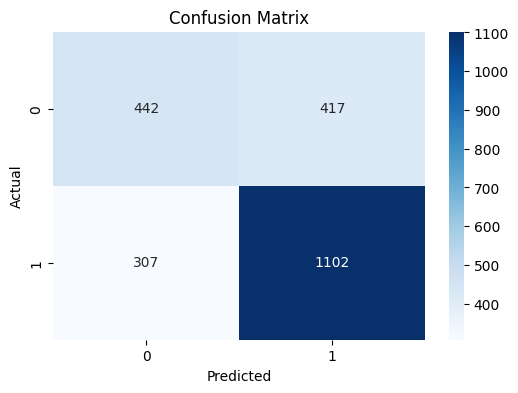

In [ ]:


cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC:", auc)


ROC-AUC: 0.718023416734761


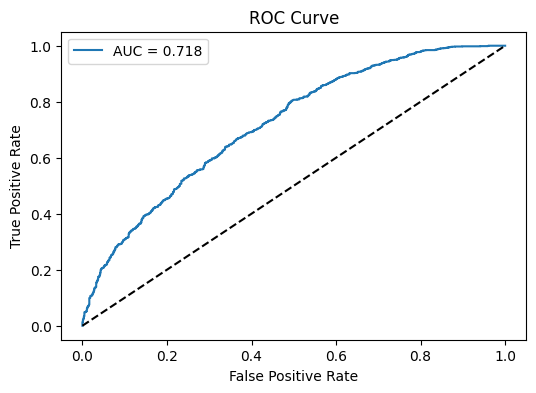

In [ ]:


fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


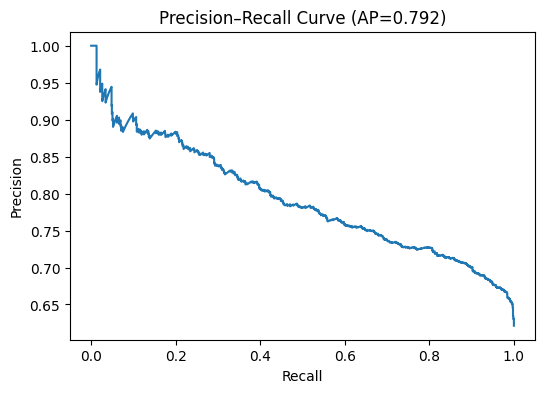

In [ ]:


precision, recall, _ = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.title(f"Precision–Recall Curve (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


The model is strongly driven by MRR-related features, especially:

mrr_tenure_1 and mrr_tenure_0 → the absolute revenue during the first two months

invoice_date_span → temporal spread of customer activity

mrr_per_subscription, mrr_max, mrr_mean, mrr_min → subscription-level value

product- and origin-based categorical features play a secondary but non-negligible role

This indicates that early revenue level and early usage/activity intensity are the dominant signals for predicting 12-month churn.

/tmp/ipython-input-127176361.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importances', y='Feature Id', data=feature_importances.head(10), palette='viridis')


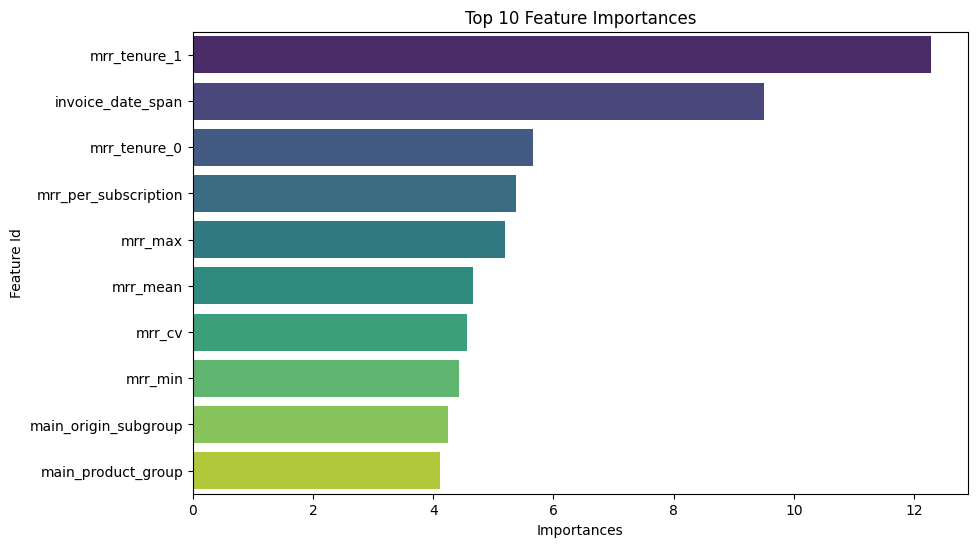

In [ ]:
feature_importances = model.get_feature_importance(prettified=True)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importances', y='Feature Id', data=feature_importances.head(10), palette='viridis')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importances')
plt.ylabel('Feature Id')
plt.show()


In [ ]:

shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

SHAP confirms the importance ranking:
High invoice_date_span and high mrr_tenure_1 push predictions toward non-churn, while low values increase churn probability.
is_business has a clear effect: business customers are less likely to churn, consistent with business logic.
Also higher activity rate (e.g more products bought) = less churn

(Grey points appear for categorical variables because CatBoost internally encodes them using quantization/target encoding, so SHAP cannot assign continuous color values)

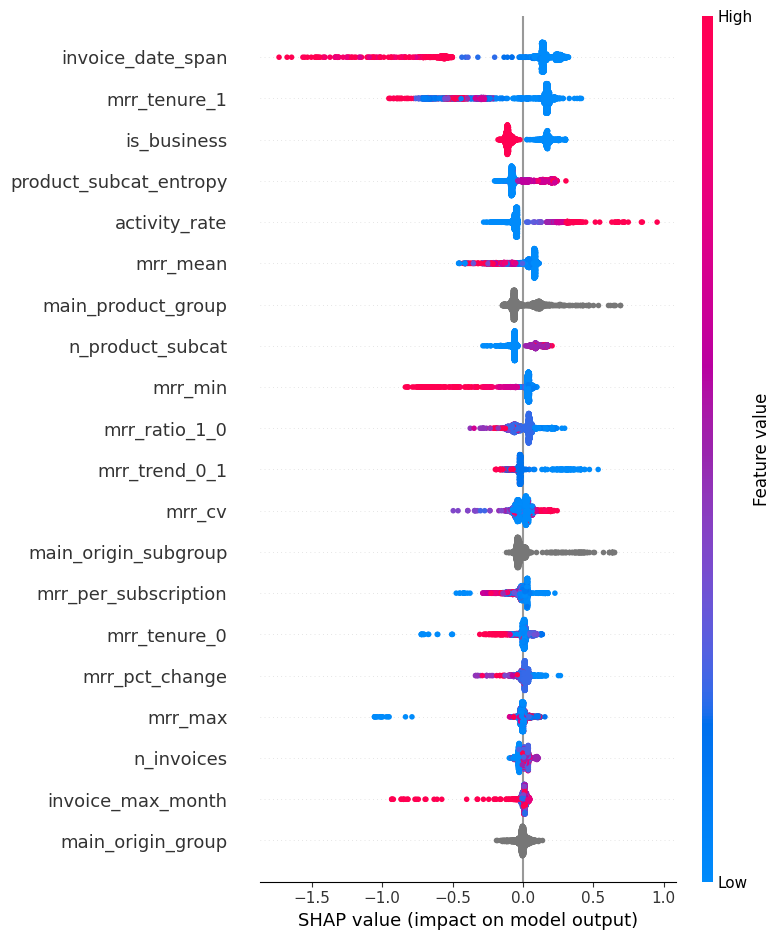

In [ ]:
shap.summary_plot(shap_values, X_test) # grey values = categoricals not handled by shap


# Conclusions

The model is capturing meaningful early patterns of customer behavior, especially through revenue-related features, activity timing, and customer type.
Performance is moderately good considering the task: predicting churn 12 months in the future based only on the first 2 months of customer life.
However, the predictions remain noisy.
Possible next steps:
1. Expand feature engineering (strongest path forward)

2. Model tuning (not done here)/ other models (like xgboost)

3. Different aggregation strategy: Model at subscription level and then aggregate predictions at customer level
